# **<center> CHE1125 - Final Project</center>**

### **<center> Abhishek Patel </center>**

In [1]:
# Importing the neccessary libraries

import cameo
import cobra
import straindesign as sd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from scipy.integrate import solve_ivp
from cameo.strain_design.deterministic.linear_programming import OptKnock
from cameo.flux_analysis import lmoma,room

sns.set_theme(context='paper', style='darkgrid', palette='brg', font='sans-serif', font_scale=2, color_codes=True)
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 369

cobra.solver = 'gurobi'
cameo.solver = 'gurobi'

%matplotlib inline

In [2]:
# Defining the neccessary Functions. To be used later in Growth Coupling.

def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_BS_10', 'EX_ribflv_e'], ['max', 'max']) # Enter name of biomass ID

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [3]:
# Importing iYO844
iYO844 = cobra.io.load_model('iYO844')

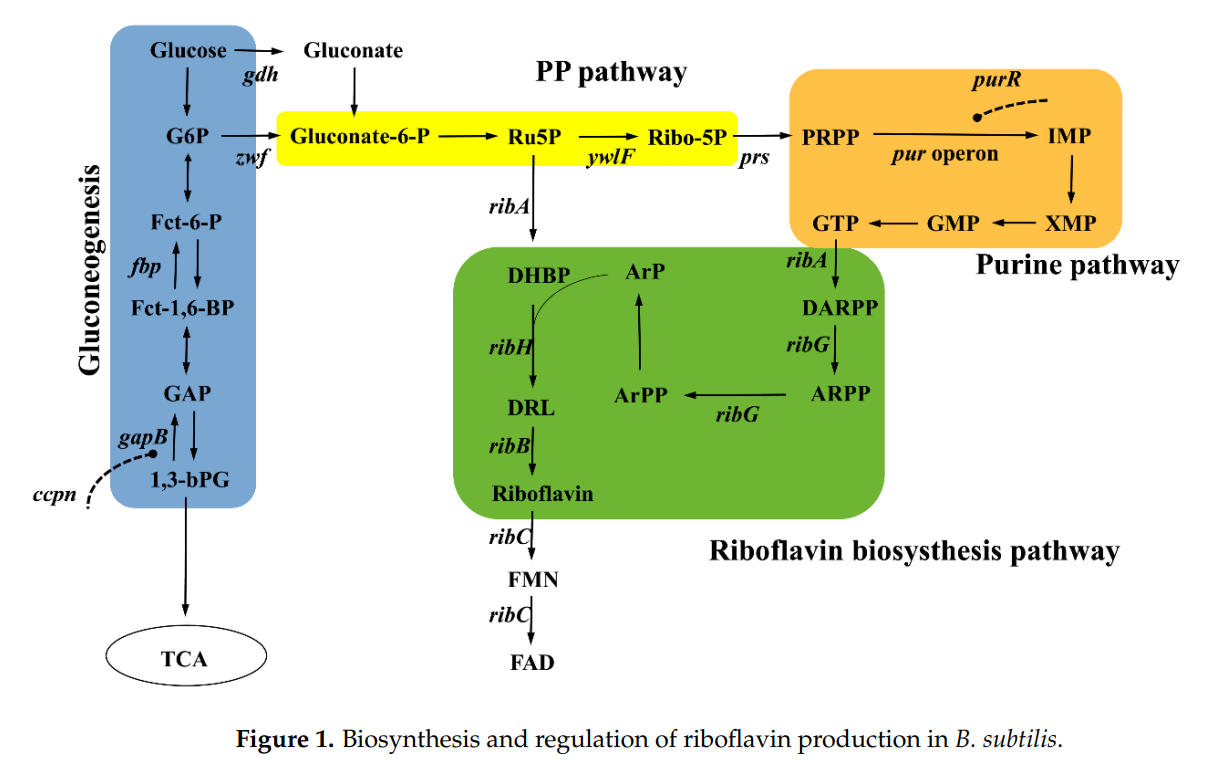

## Wild Type iYO844




### Fluxes for IMP reactions on WT iYO844

In [4]:
# Calculating Fluxes for the whole pathway displayed above. The FMN and FAD reactions have been excluded as seen below:### FBA on iYO844

with iYO844:
    display(pd.DataFrame(iYO844.optimize(max).fluxes[['GND', 'RPI', 'PRPPS', 
                                                      'XPPT', 'GMPS2', 'GK1', 
                                                      'NDPK1', 'GTPCII', 'DHPPDA', 
                                                      'APRAUR', 'PMDPHT', 'RBFSa', 
#                                                       'FLVR_1', 'RIBFLVt2', 'RBFK', 'FMNAT',
                                                      'RBFSb', 'BIOMASS_BS_10', 'EX_ribflv_e']]))

,fluxes
GND,0.000000
RPI,-0.048071
PRPPS,0.051919
XPPT,0.000000
GMPS2,0.009569
GK1,0.007457
NDPK1,0.028997
GTPCII,0.000000
DHPPDA,0.000000
APRAUR,0.000000


### FBA on WT iYO844

In [5]:
fba_result = iYO844.optimize()
fba_biomass = fba_result.objective_value
fba_ribflv = fba_result.fluxes['EX_ribflv_e']

# print(f"The Growth of the new strain is", fba_result)
print(f"The Growth rate of the WT strain is", fba_biomass)
print(f"The Flux of Riboflavin of the WT strain is", fba_ribflv)

The Growth rate of the WT strain is 0.11796638932240115
The Flux of Riboflavin of the WT strain is 0.0


**`As it can been that there is no Riboflavin production naturally in the Wild-Type state of this bacteria strain however it has a high Biomass production of 0.118`**

### MOMA on WT iYO844

Growth rate predicted by FBA:  0.11796638932240115
Riboflavin flux predicted by FBA:  0.0
Growth rate predicted by MOMA  0.11796638932240087
Riboflavin flux predicted by MOMA:  0.0
According to FVA, the minimum is  0.0 and the maximum is 3.0730988579344024e-15


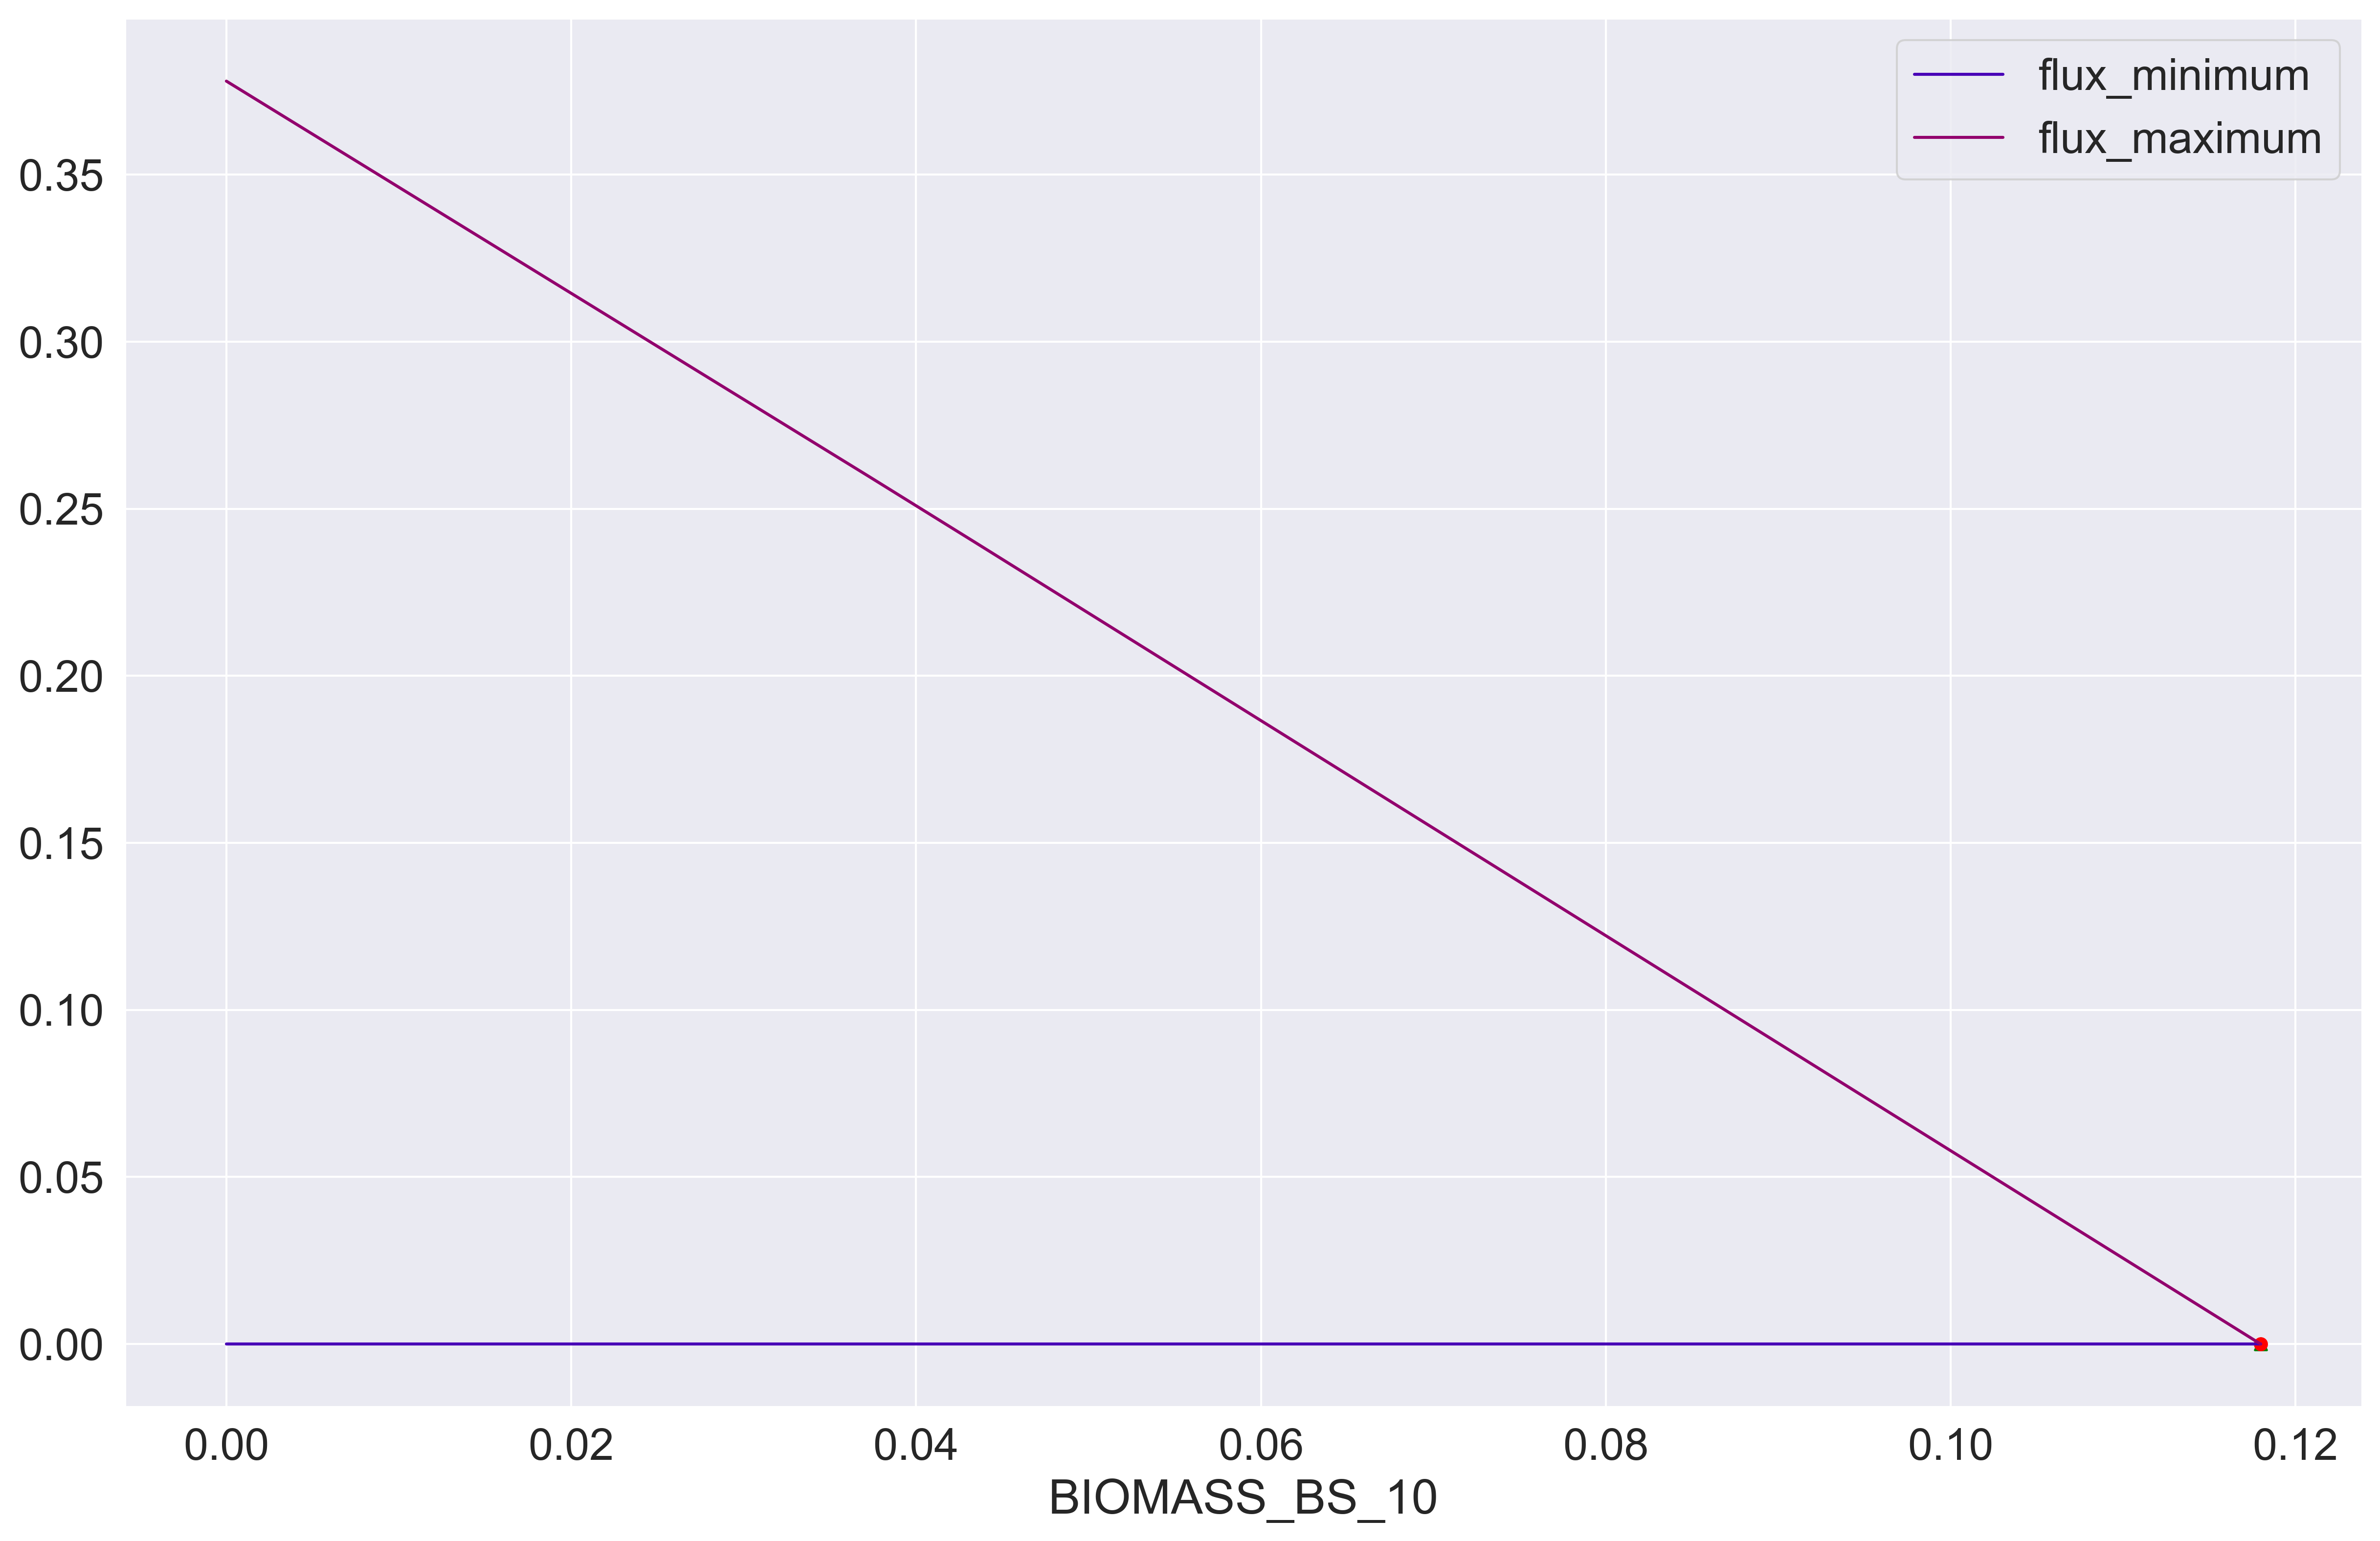

In [6]:
# iYO844 = cobra.io.load_model('iYO844')
with iYO844:
    ref_flux = iYO844.optimize()
#     for s in results.data_frame.reactions[3]:
#         iYO844.reactions.get_by_id(s).knock_out()
    moma_result = cobra.flux_analysis.moma(model = iYO844, solution = ref_flux)
    fba_result = iYO844.optimize()
    fba_biomass = fba_result.objective_value
    fba_ribflv = fba_result.fluxes['EX_ribflv_e']
    moma_biomass = moma_result.fluxes['BIOMASS_BS_10']
    moma_ribflv = moma_result.fluxes['EX_ribflv_e']
    prod_env = cobra.flux_analysis.production_envelope(iYO844, ["BIOMASS_BS_10"], objective = "EX_ribflv_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_BS_10', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ribflv, marker = '^', c = 'green')
    plt.scatter(moma_biomass, moma_ribflv, marker = 'o', c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Riboflavin flux predicted by FBA: ", fba_ribflv)
    print("Growth rate predicted by MOMA ", moma_biomass)
    print("Riboflavin flux predicted by MOMA: ", moma_ribflv)
    fva_result = cobra.flux_analysis.flux_variability_analysis(iYO844, iYO844.reactions, fraction_of_optimum = 1)
    print("According to FVA, the minimum is ", fva_result['minimum']["EX_ribflv_e"], "and the maximum is", fva_result['maximum']["EX_ribflv_e"])

**`The Biomass value for MOMA is indicated at 0.12`**

### ROOM on WT iYO844

Growth rate predicted by FBA:  0.1179663893223987
Riboflavin flux predicted by FBA:  0.0
Growth rate predicted by ROOM  0.11442739764272672
Riboflavin flux predicted by ROOM:  0.0


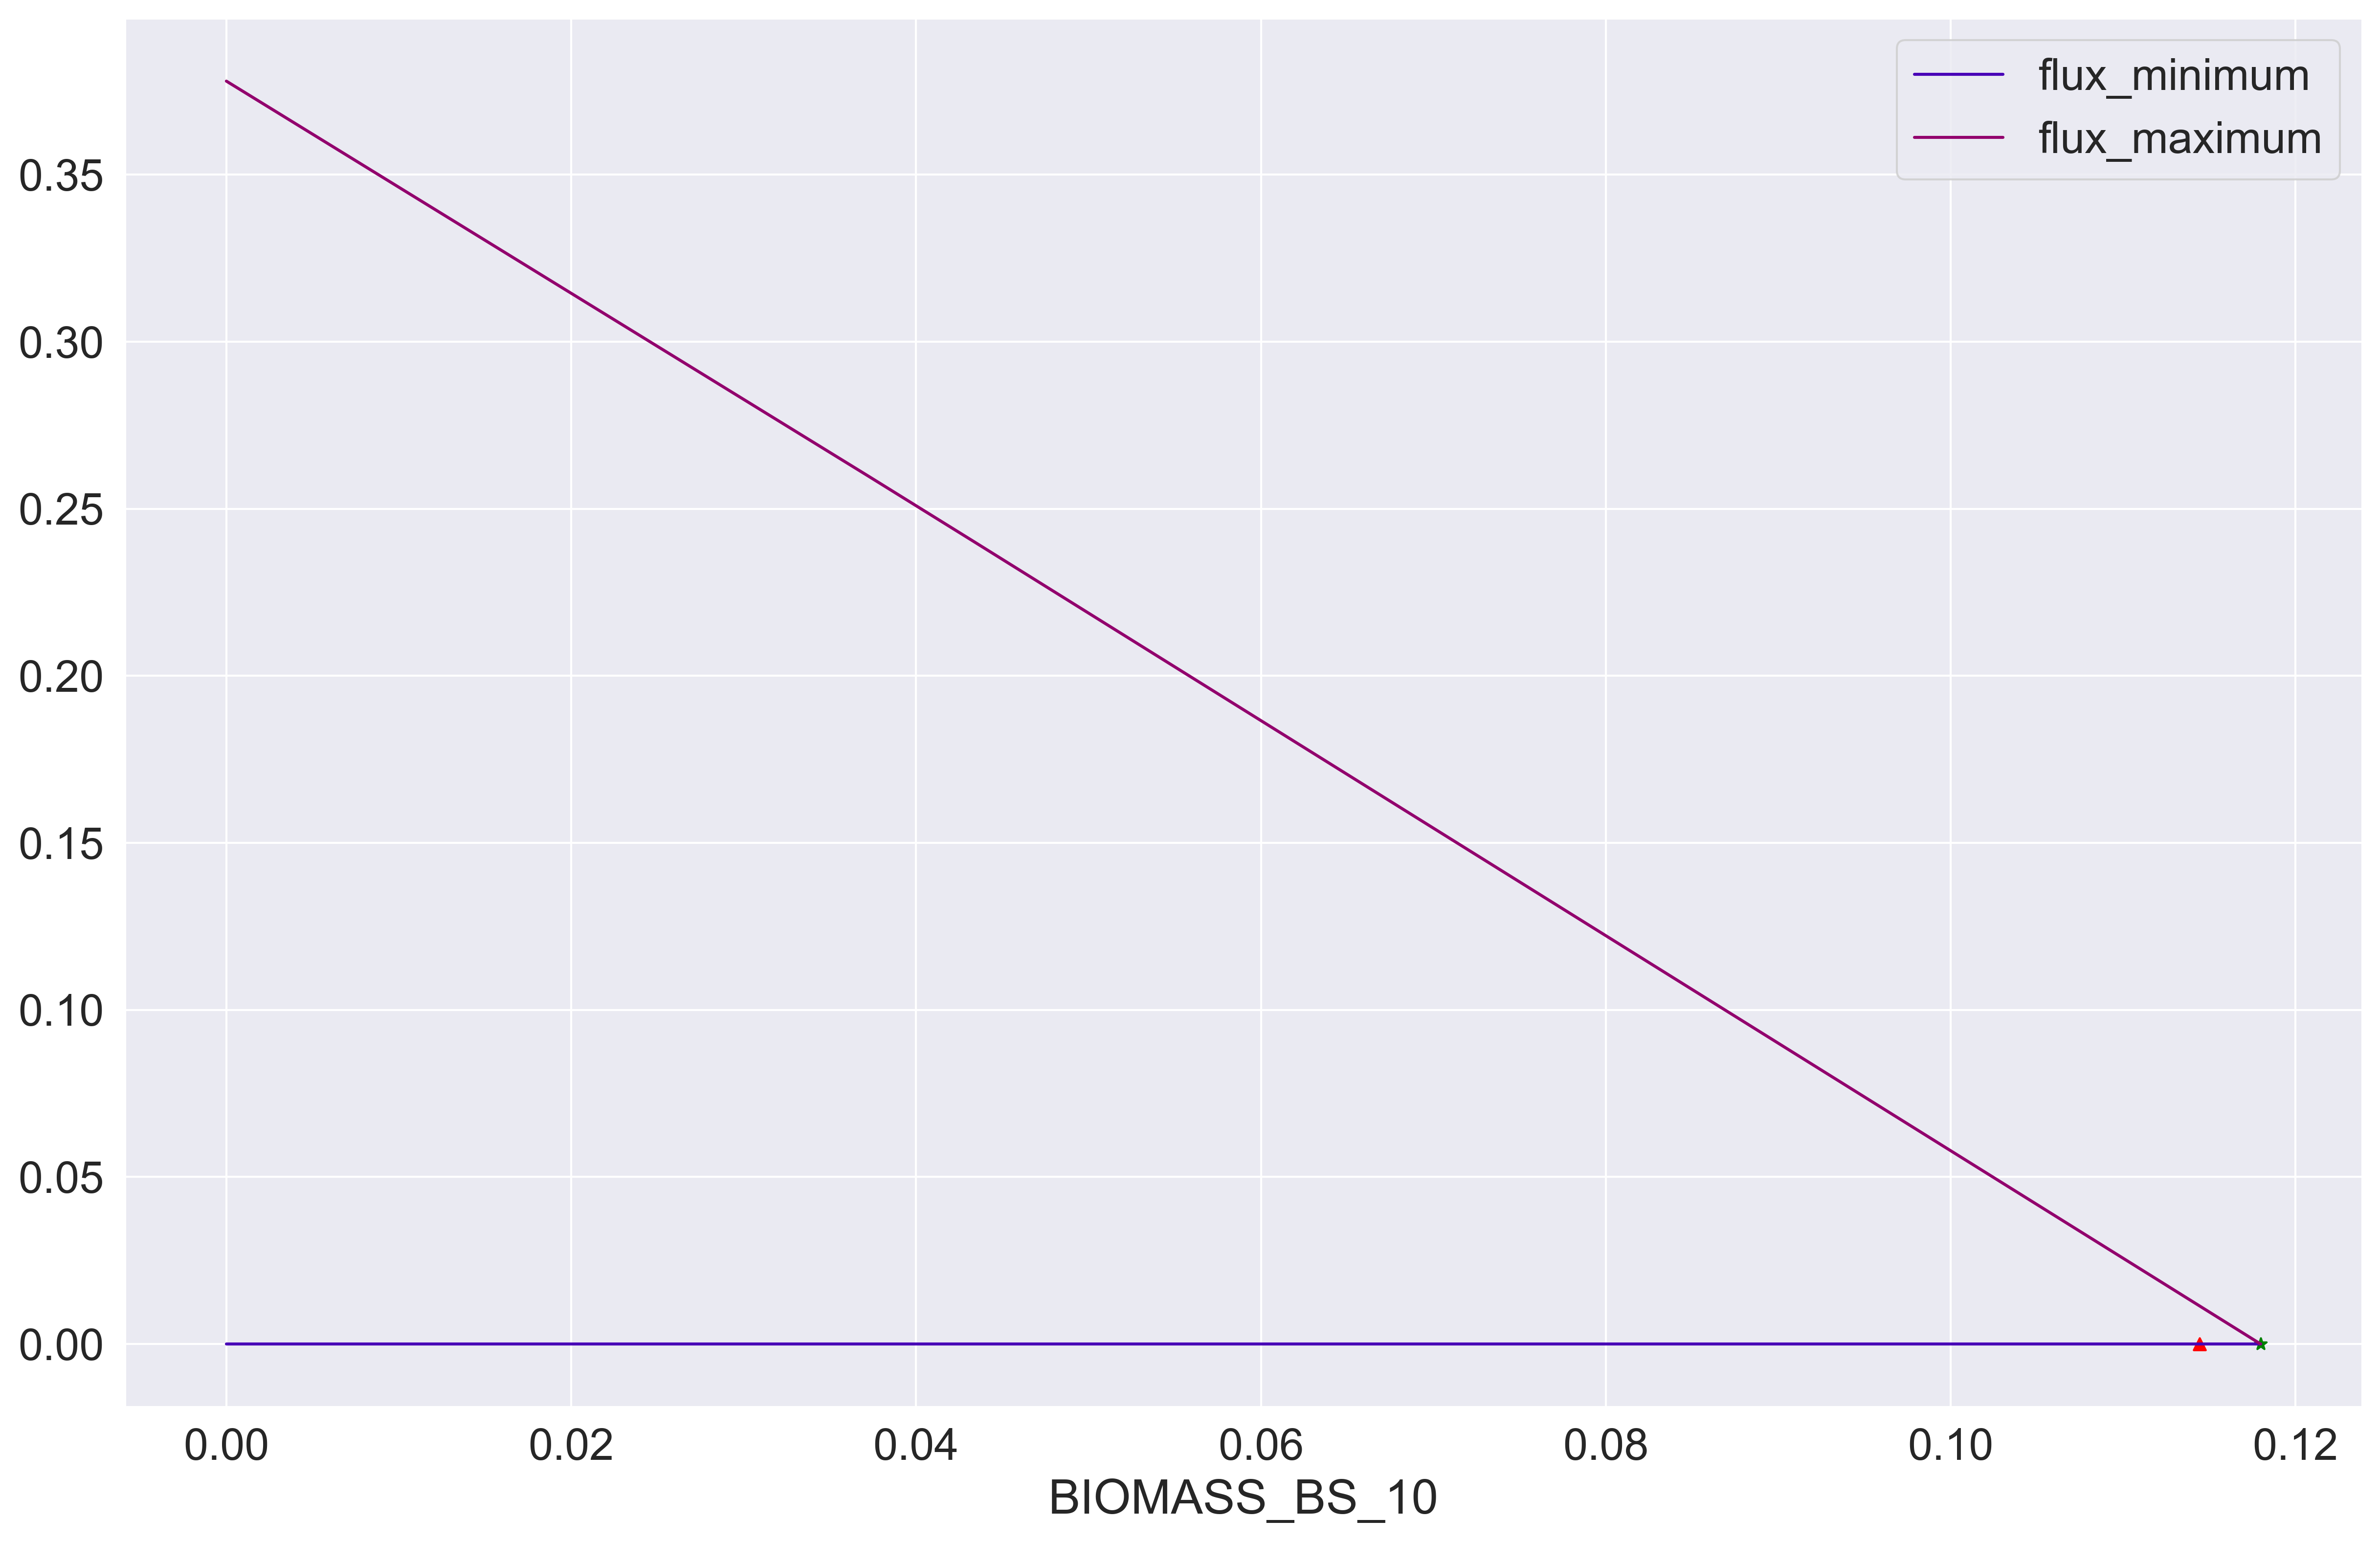

In [7]:
# iYO844 = cobra.io.load_model('iYO844')
with iYO844:
    for reaction in iYO844.reactions: # Will run forever without this
        if reaction.upper_bound == 1000:
            reaction.upper_bound = 99999999
        if reaction.lower_bound == -1000:
            reaction.lower_bound = -99999999
    ref_flux = iYO844.optimize()
#     for s in results.data_frame.reactions[3]:
#         iYO844.reactions.get_by_id(s).knock_out()
    room_result = cobra.flux_analysis.room(model = iYO844, solution = ref_flux, linear = 0)
    fba_result = iYO844.optimize()
    fba_biomass = fba_result.objective_value
    fba_ribflv = fba_result.fluxes['EX_ribflv_e']
    room_biomass = room_result.fluxes['BIOMASS_BS_10']
    room_ribflv = room_result.fluxes['EX_ribflv_e']
    prod_env = cobra.flux_analysis.production_envelope(iYO844, ["BIOMASS_BS_10"], objective = "EX_ribflv_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_BS_10', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ribflv, marker = '*', c = 'green')
    plt.scatter(room_biomass,room_ribflv, marker = '^', c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Riboflavin flux predicted by FBA: ", fba_ribflv)
    print("Growth rate predicted by ROOM ", room_biomass)
    print("Riboflavin flux predicted by ROOM: ", room_ribflv)

**`The Biomass value for ROOM is indicated at 0.12`**

### Growth Coupling of Riboflavin of WT iYO844

In [8]:
model = iYO844 
ts = np.linspace(0, 20, 10)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 20.000: : 225it [17:59,  4.80s/it]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.222e+00  4.444e+00  6.667e+00  8.889e+00
             1.111e+01  1.333e+01  1.556e+01  1.778e+01  2.000e+01]
        y: [[ 1.000e-01  3.472e-01 ...  2.113e+03  7.336e+03]
            [ 1.000e+01  1.000e+01 ...  1.000e+01  1.000e+01]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 222
     njev: 1
      nlu: 23

Text(0, 0.5, 'Riboflavin')

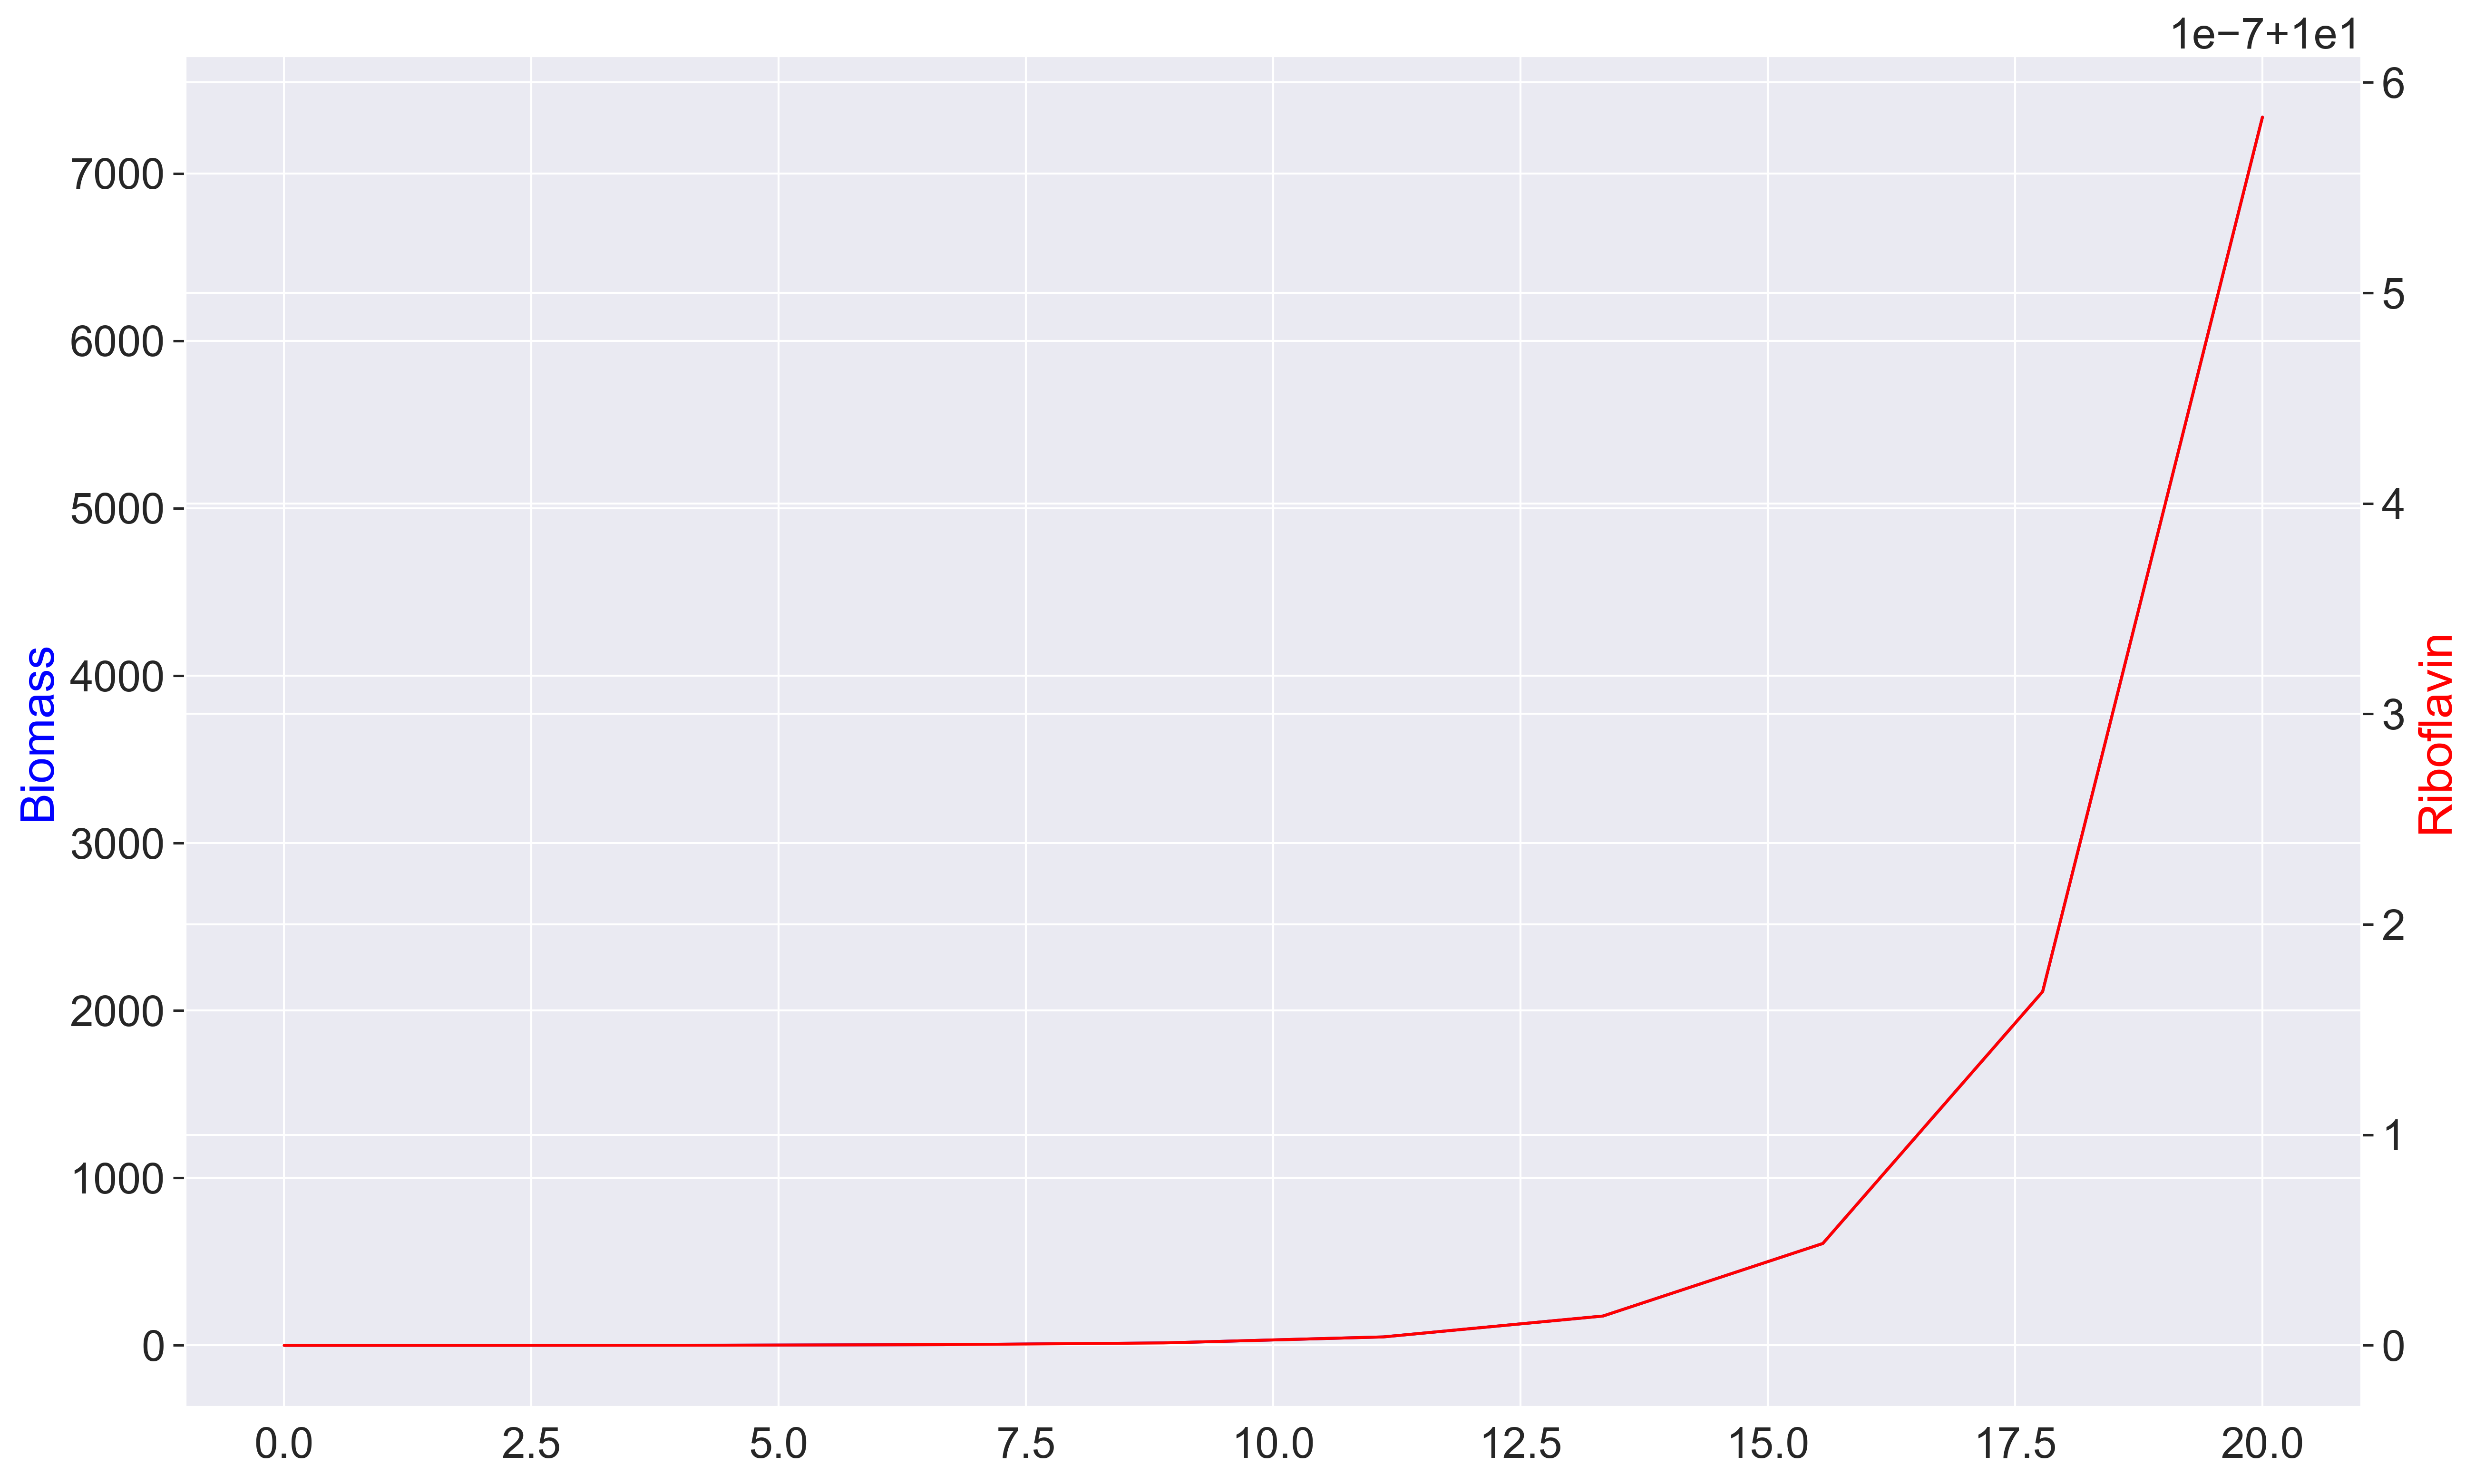

In [9]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Riboflavin', color='r')

In [10]:
model = iYO844 
ts = np.linspace(30, 40, 20)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 40.000: : 135it [15:49,  7.03s/it]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 3.000e+01  3.053e+01 ...  3.947e+01  4.000e+01]
        y: [[ 1.000e-01  1.343e-01 ...  2.017e+01  2.709e+01]
            [ 1.000e+01  1.000e+01 ...  1.000e+01  1.000e+01]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 132
     njev: 1
      nlu: 15

Text(0, 0.5, 'Riboflavin')

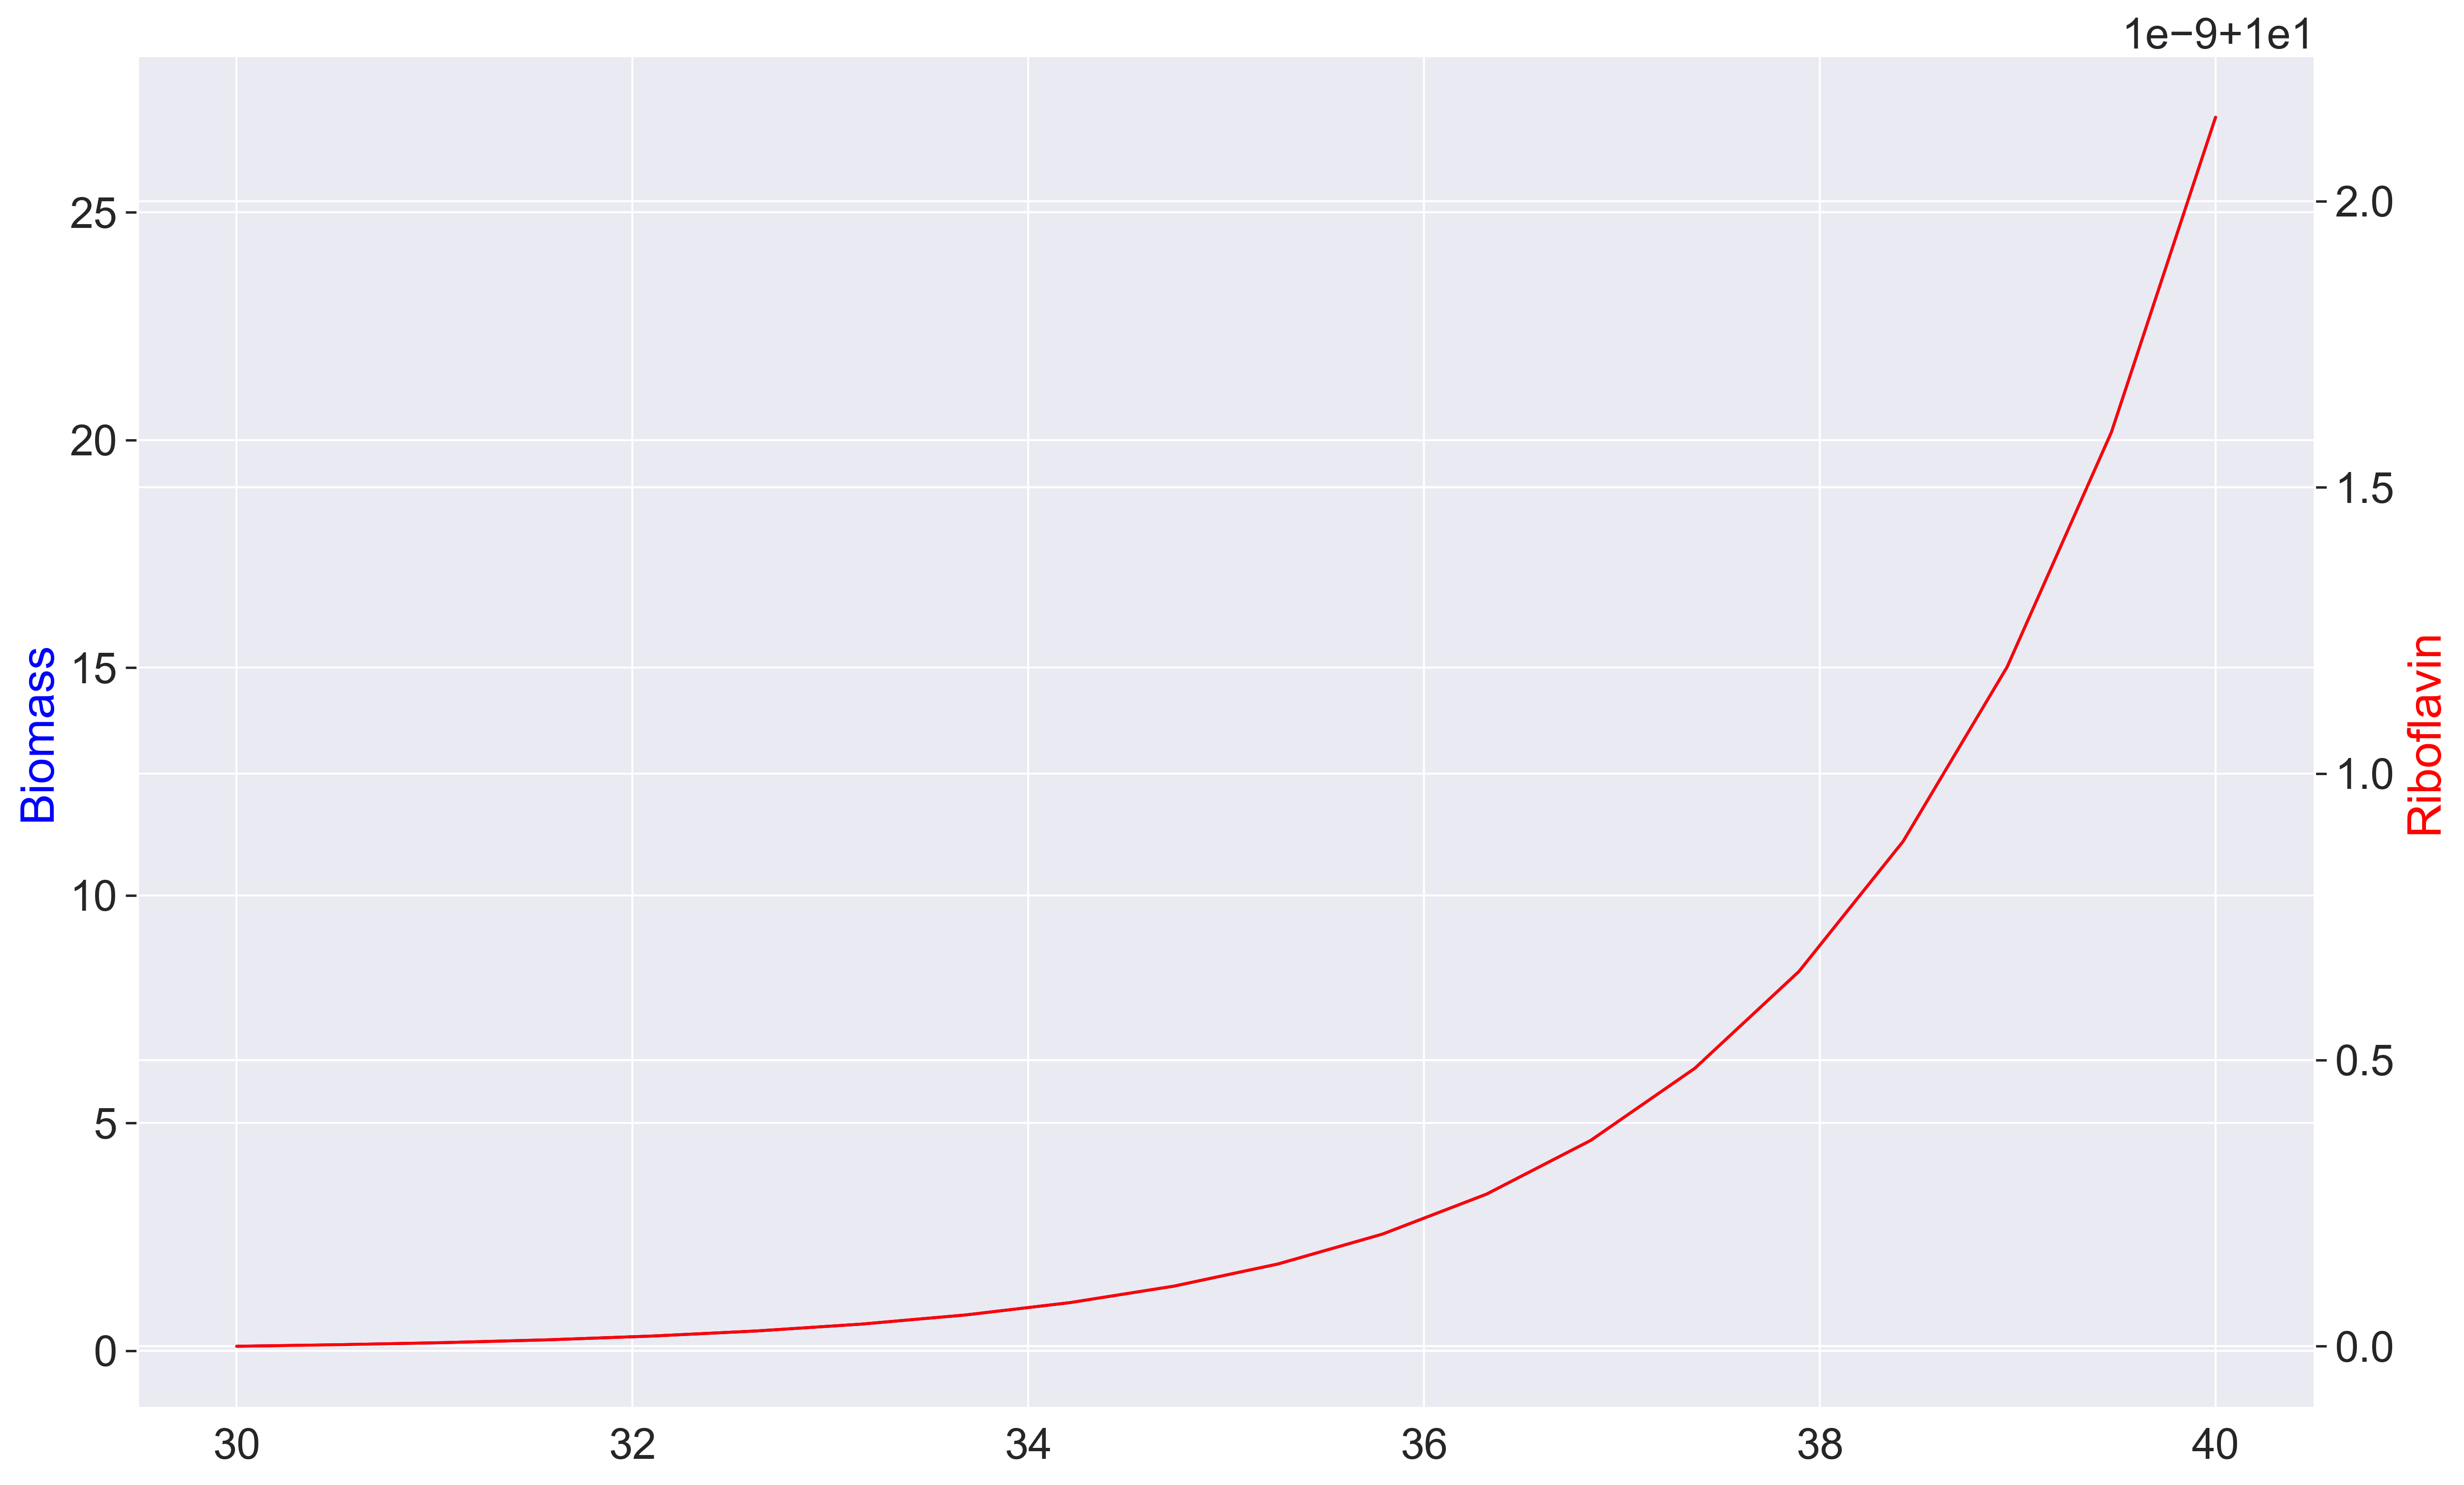

In [11]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Riboflavin', color='r')

### Changing the bounds of 'EX_ribflv_e'

`Changing the bounds of this reaction is essential to make it eligible for this simulation to work otherwise with the bounds in it natural state, they are too wide for the` **'optknock'** `function to capture it as a possiblility and make it a target.` **(It gives a KeyError)** `Thus important to make feasible bound changes.`

*`These bounds were selected after a lot of trial and error.`*

In [12]:
iYO844.reactions.EX_ribflv_e

Reaction identifier,EX_ribflv_e
Name,Riboflavin exchange
Memory address,0x01e524852f40
Stoichiometry,ribflv_e --> Riboflavin C17H20N4O6 -->
GPR,
Lower bound,0.0
Upper bound,999999.0


In [13]:
iYO844.reactions.EX_ribflv_e.lower_bound = 0.1
iYO844.reactions.EX_ribflv_e.upper_bound = 10000

In [14]:
iYO844.reactions.EX_ribflv_e

Reaction identifier,EX_ribflv_e
Name,Riboflavin exchange
Memory address,0x01e524852f40
Stoichiometry,ribflv_e --> Riboflavin C17H20N4O6 -->
GPR,
Lower bound,0.1
Upper bound,10000


## Optimal Knockout Reactions from WT iYO844

In [15]:
optknock = OptKnock(iYO844, fraction_of_optimum = 1)


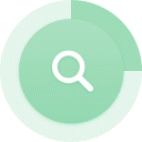

<IPython.core.display.Javascript object>

In [16]:
results = optknock.run(max_knockouts=7, target=['EX_ribflv_e'], biomass='BIOMASS_BS_10', max_results=20)

In [17]:
results.data_frame

HBox()

,reactions,size,EX_ribflv_e,biomass,fva_min,fva_max
0,{},0,0.1,0.086901,0.1,0.102797
1,{ORNTA_1},1,0.1,0.086901,0.1,0.102797
2,{ILETA},1,0.1,0.086901,0.1,0.102797
3,{LEUTA},1,0.1,0.086901,0.1,0.102797
4,{FBA2},1,0.1,0.086901,0.1,0.102797
5,{GK1},1,0.1,0.086901,0.1,0.102797
6,{MGt5},1,0.1,0.086901,0.1,0.102797
7,"{ILETA, LEUTA}",2,0.1,0.086901,0.1,0.102797
8,"{IMPD, FBA2, PRO1x}",3,0.1,0.086901,0.1,0.102797
9,"{IMPD, VALDHr, PRO1x}",3,0.1,0.086901,0.1,0.102797


**`Looking at the results, it seems that selecting any one of these sets would give the same Growth Rate and Same Riboflavin Production Flux.`**

In [18]:
results.data_frame.reactions[3]

{'LEUTA'}

**`Knocking out the selected reaction set from the WT iYO844 to create a new strain.`**

In [19]:
for s in results.data_frame.reactions[3]:
        iYO844.reactions.get_by_id(s).knock_out()

### Fluxes for IMP reactions on New iYO844 strain

In [20]:
with iYO844:
    display(pd.DataFrame(iYO844.optimize(max).fluxes[['GND', 'RPI', 'PRPPS', 
                                                      'XPPT', 'GMPS2', 'GK1', 
                                                      'NDPK1', 'GTPCII', 'DHPPDA', 
                                                      'APRAUR', 'PMDPHT', 'RBFSa', 
#                                                       'FLVR_1', 'RIBFLVt2', 'RBFK', 'FMNAT',
                                                      'RBFSb', 'BIOMASS_BS_10', 'EX_ribflv_e']]))

,fluxes
GND,1.037306e-16
RPI,-3.541189e-02
PRPPS,1.382464e-01
XPPT,1.070489e-01
GMPS2,1.070489e-01
GK1,1.054933e-01
NDPK1,1.213609e-01
GTPCII,1.000000e-01
DHPPDA,1.000000e-01
APRAUR,1.000000e-01


### FBA on New iYO844 strain

In [21]:
fba_result = iYO844.optimize()
fba_biomass = fba_result.objective_value
fba_ribflv = fba_result.fluxes['EX_ribflv_e']

# print(f"The Growth of the new strain is", fba_result)
print(f"The Growth rate of the new strain is", fba_biomass)
print(f"The Flux of Riboflavin of the new strain is", fba_ribflv)

The Growth rate of the new strain is 0.08690062815511769
The Flux of Riboflavin of the new strain is 0.1


**`As it can been that there is 0.1 Riboflavin production in the New bacteria strain & it has a high enough Biomass production of 0.0869.`**

### MOMA on New iYO844 strain

Growth rate predicted by FBA:  0.08690062815511769
Riboflavin flux predicted by FBA:  0.1
Growth rate predicted by MOMA  0.08690062815511126
Riboflavin flux predicted by MOMA:  0.1
According to FVA, the minimum is  0.1 and the maximum is 0.10000000000001685


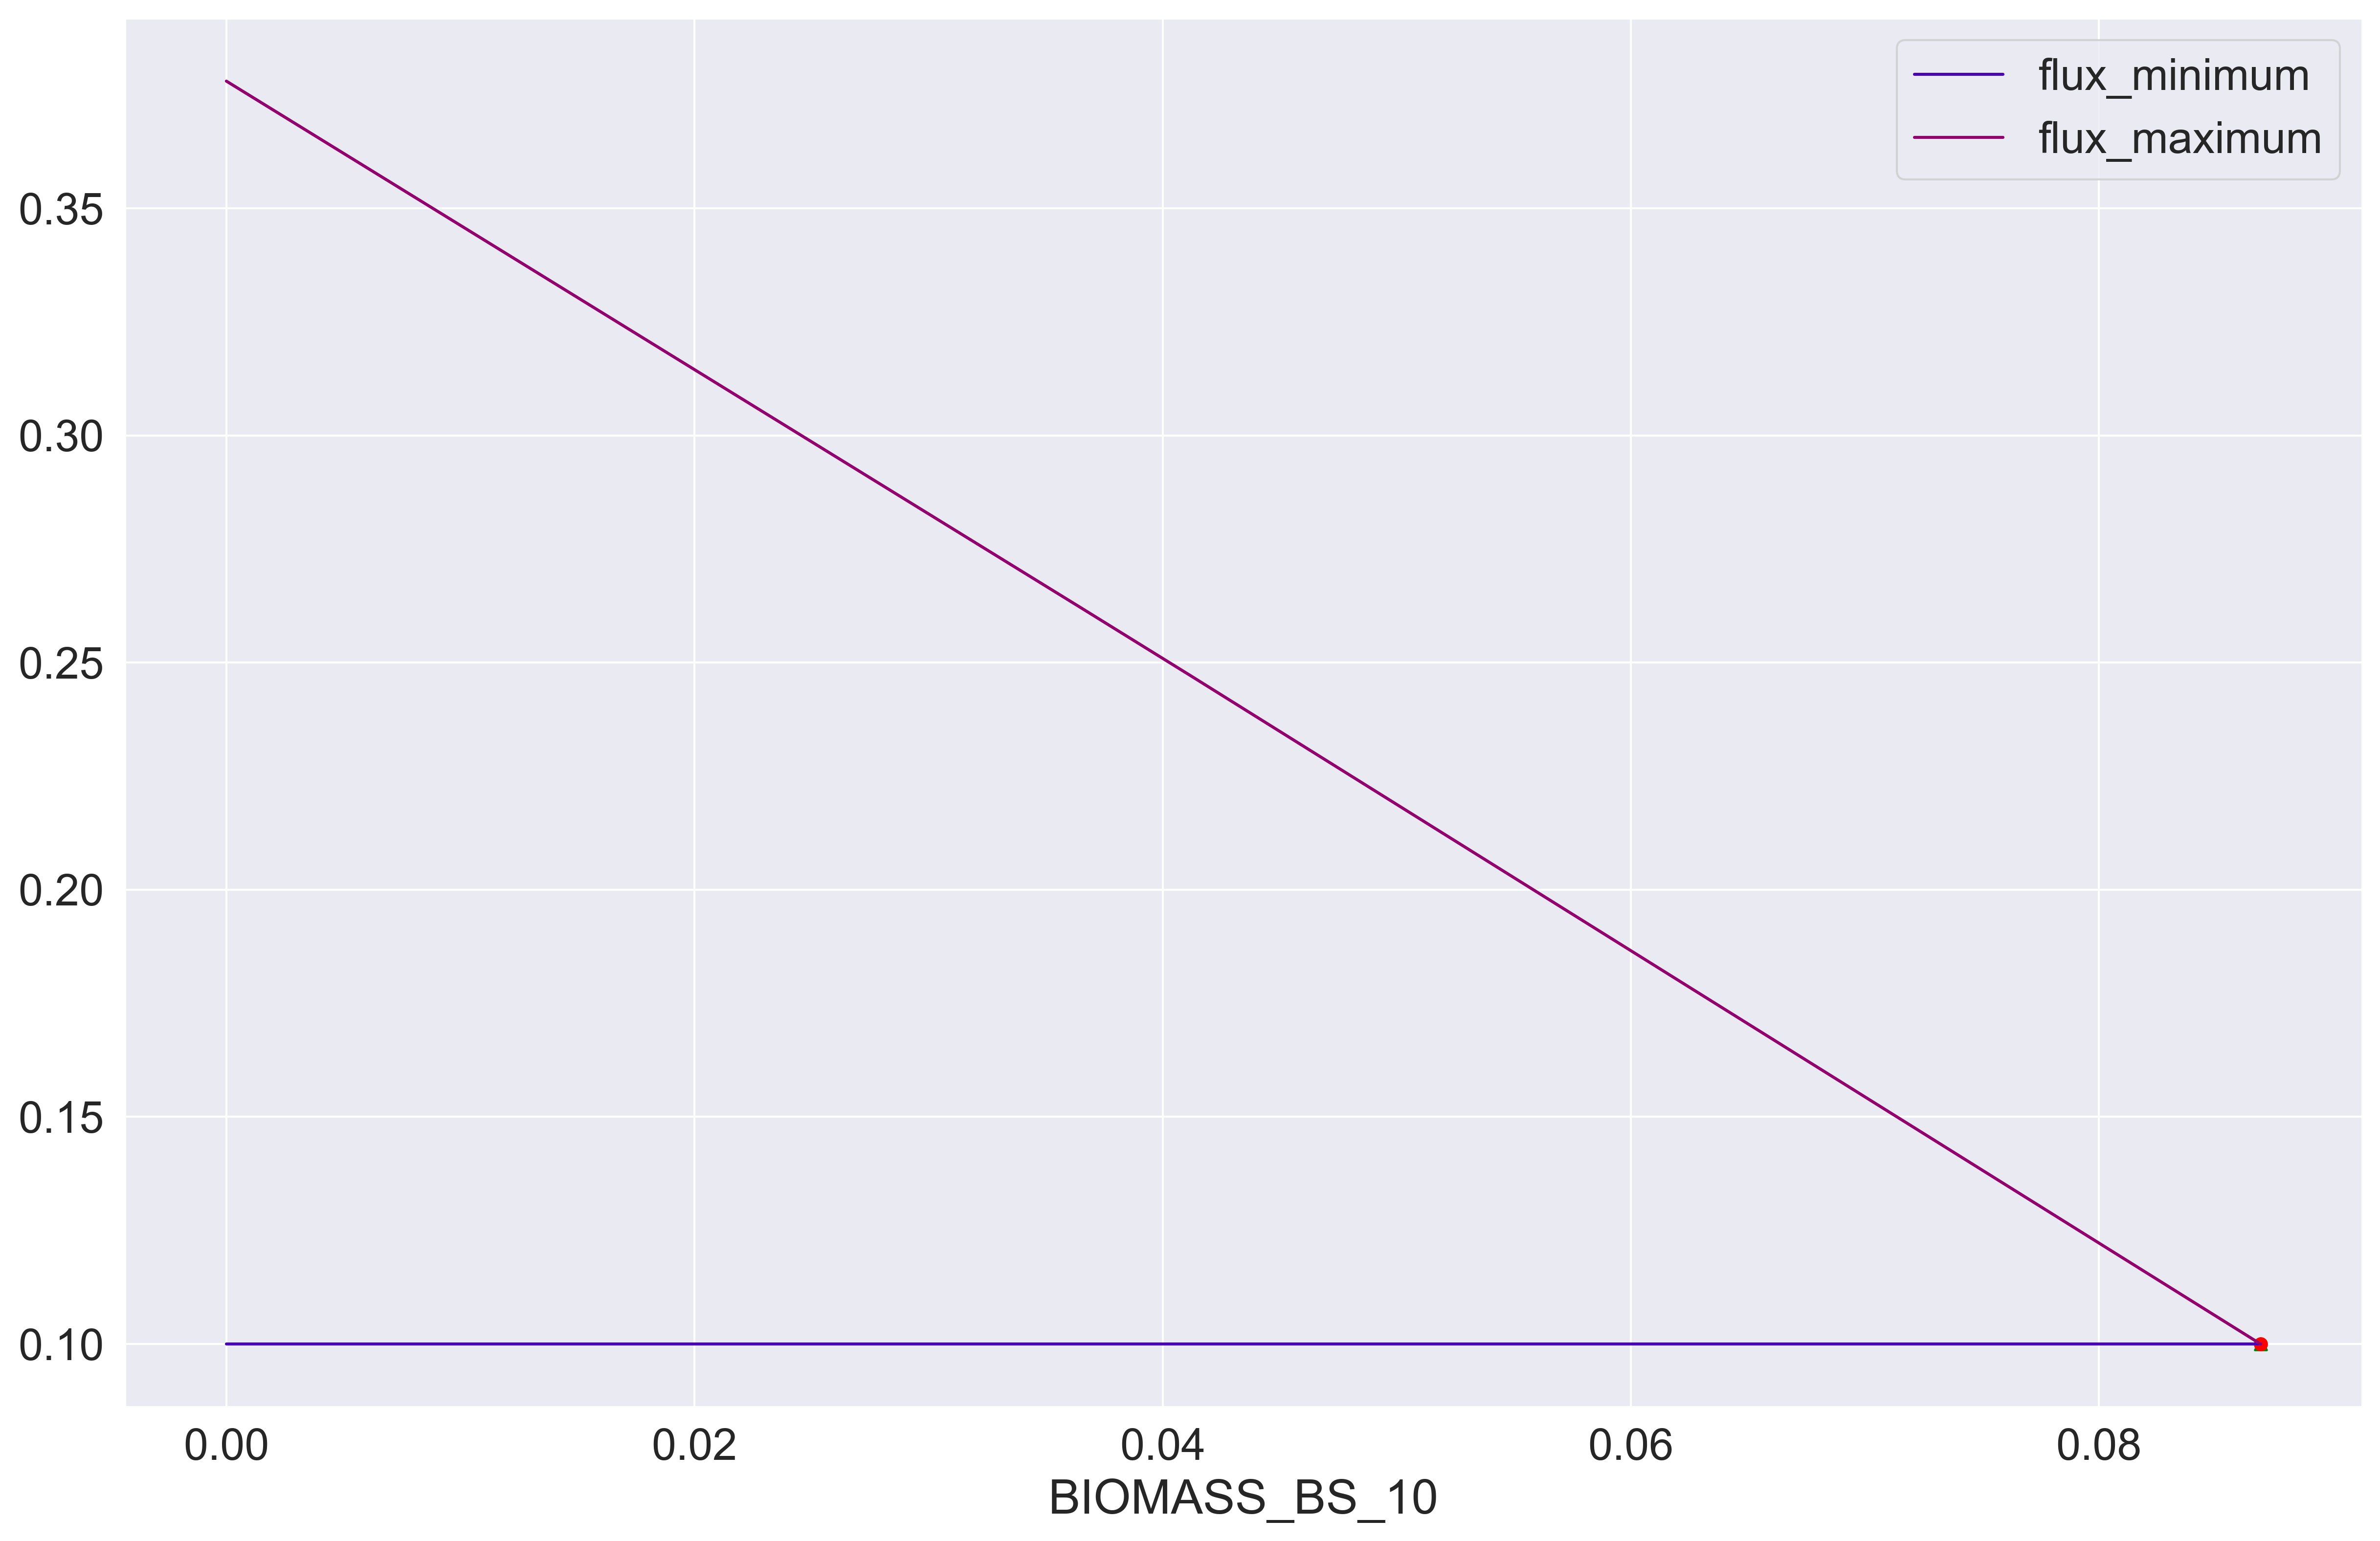

In [22]:
# iYO844 = cobra.io.load_model('iYO844')
with iYO844:
    ref_flux = iYO844.optimize()
    for s in results.data_frame.reactions[3]:
        iYO844.reactions.get_by_id(s).knock_out()
    moma_result = cobra.flux_analysis.moma(model = iYO844, solution = ref_flux)
    fba_result = iYO844.optimize()
    fba_biomass = fba_result.objective_value
    fba_ribflv = fba_result.fluxes['EX_ribflv_e']
    moma_biomass = moma_result.fluxes['BIOMASS_BS_10']
    moma_ribflv = moma_result.fluxes['EX_ribflv_e']
    prod_env = cobra.flux_analysis.production_envelope(iYO844, ["BIOMASS_BS_10"], objective = "EX_ribflv_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_BS_10', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ribflv, marker = '^', c = 'green')
    plt.scatter(moma_biomass, moma_ribflv, marker = 'o', c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Riboflavin flux predicted by FBA: ", fba_ribflv)
    print("Growth rate predicted by MOMA ", moma_biomass)
    print("Riboflavin flux predicted by MOMA: ", moma_ribflv)
    fva_result = cobra.flux_analysis.flux_variability_analysis(iYO844, iYO844.reactions, fraction_of_optimum = 1)
    print("According to FVA, the minimum is ", fva_result['minimum']["EX_ribflv_e"], "and the maximum is", fva_result['maximum']["EX_ribflv_e"])

### ROOM on New iYO844 strain

Growth rate predicted by FBA:  0.08690062815511237
Riboflavin flux predicted by FBA:  0.1
Growth rate predicted by ROOM  0.083293609310459
Riboflavin flux predicted by ROOM:  0.1


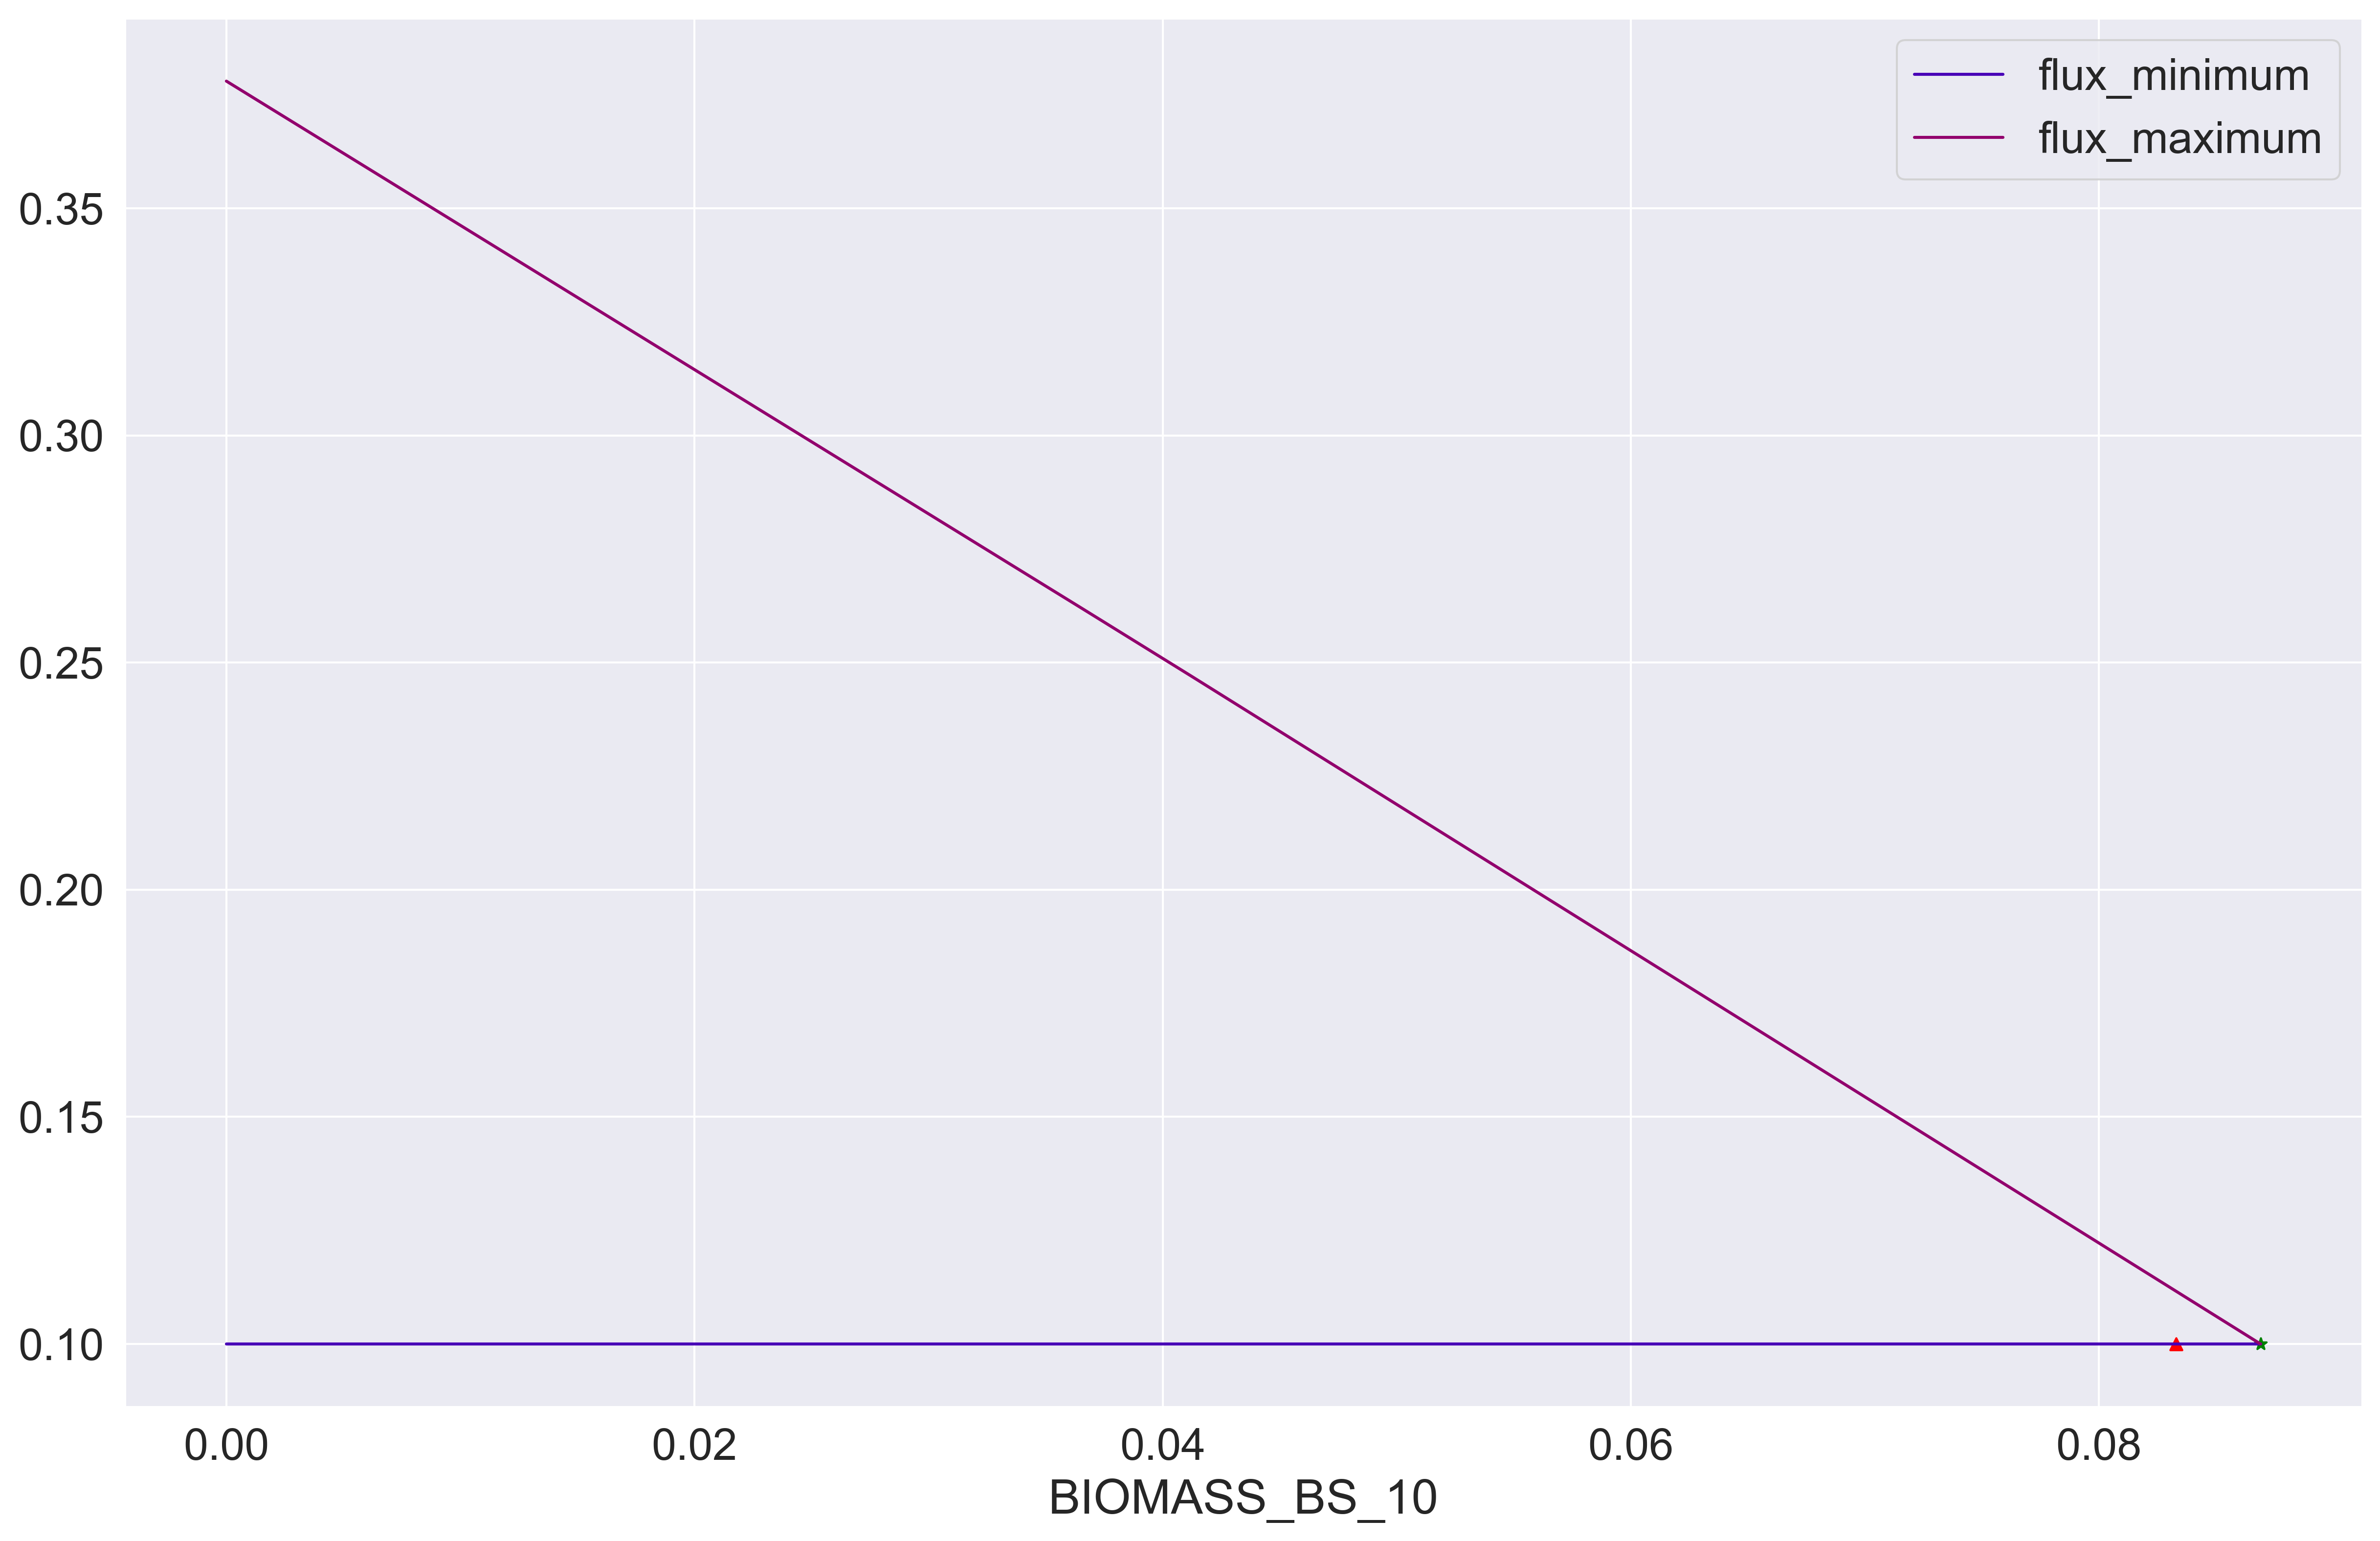

In [23]:
# iYO844 = cobra.io.load_model('iYO844')
with iYO844:
    for reaction in iYO844.reactions: # Will run forever without this
        if reaction.upper_bound == 1000:
            reaction.upper_bound = 99999999
        if reaction.lower_bound == -1000:
            reaction.lower_bound = -99999999
    ref_flux = iYO844.optimize()
    for s in results.data_frame.reactions[3]:
        iYO844.reactions.get_by_id(s).knock_out()
    room_result = cobra.flux_analysis.room(model = iYO844, solution = ref_flux, linear = 0)
    fba_result = iYO844.optimize()
    fba_biomass = fba_result.objective_value
    fba_ribflv = fba_result.fluxes['EX_ribflv_e']
    room_biomass = room_result.fluxes['BIOMASS_BS_10']
    room_ribflv = room_result.fluxes['EX_ribflv_e']
    prod_env = cobra.flux_analysis.production_envelope(iYO844, ["BIOMASS_BS_10"], objective = "EX_ribflv_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_BS_10', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ribflv, marker = '*', c = 'green')
    plt.scatter(room_biomass,room_ribflv, marker = '^', c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Riboflavin flux predicted by FBA: ", fba_ribflv)
    print("Growth rate predicted by ROOM ", room_biomass)
    print("Riboflavin flux predicted by ROOM: ", room_ribflv)

### Growth Coupling of Riboflavin of New iYO844 Strain

In [24]:
model = iYO844 
ts = np.linspace(0, 20, 10)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 20.000: : 277it [21:41,  4.70s/it]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.222e+00  4.444e+00  6.667e+00  8.889e+00
             1.111e+01  1.333e+01  1.556e+01  1.778e+01  2.000e+01]
        y: [[ 1.000e-01  3.243e-01 ...  1.946e+03  6.972e+03]
            [ 1.000e+01  1.004e+01 ...  3.490e+02  1.224e+03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 274
     njev: 1
      nlu: 25

Text(0, 0.5, 'Riboflavin')

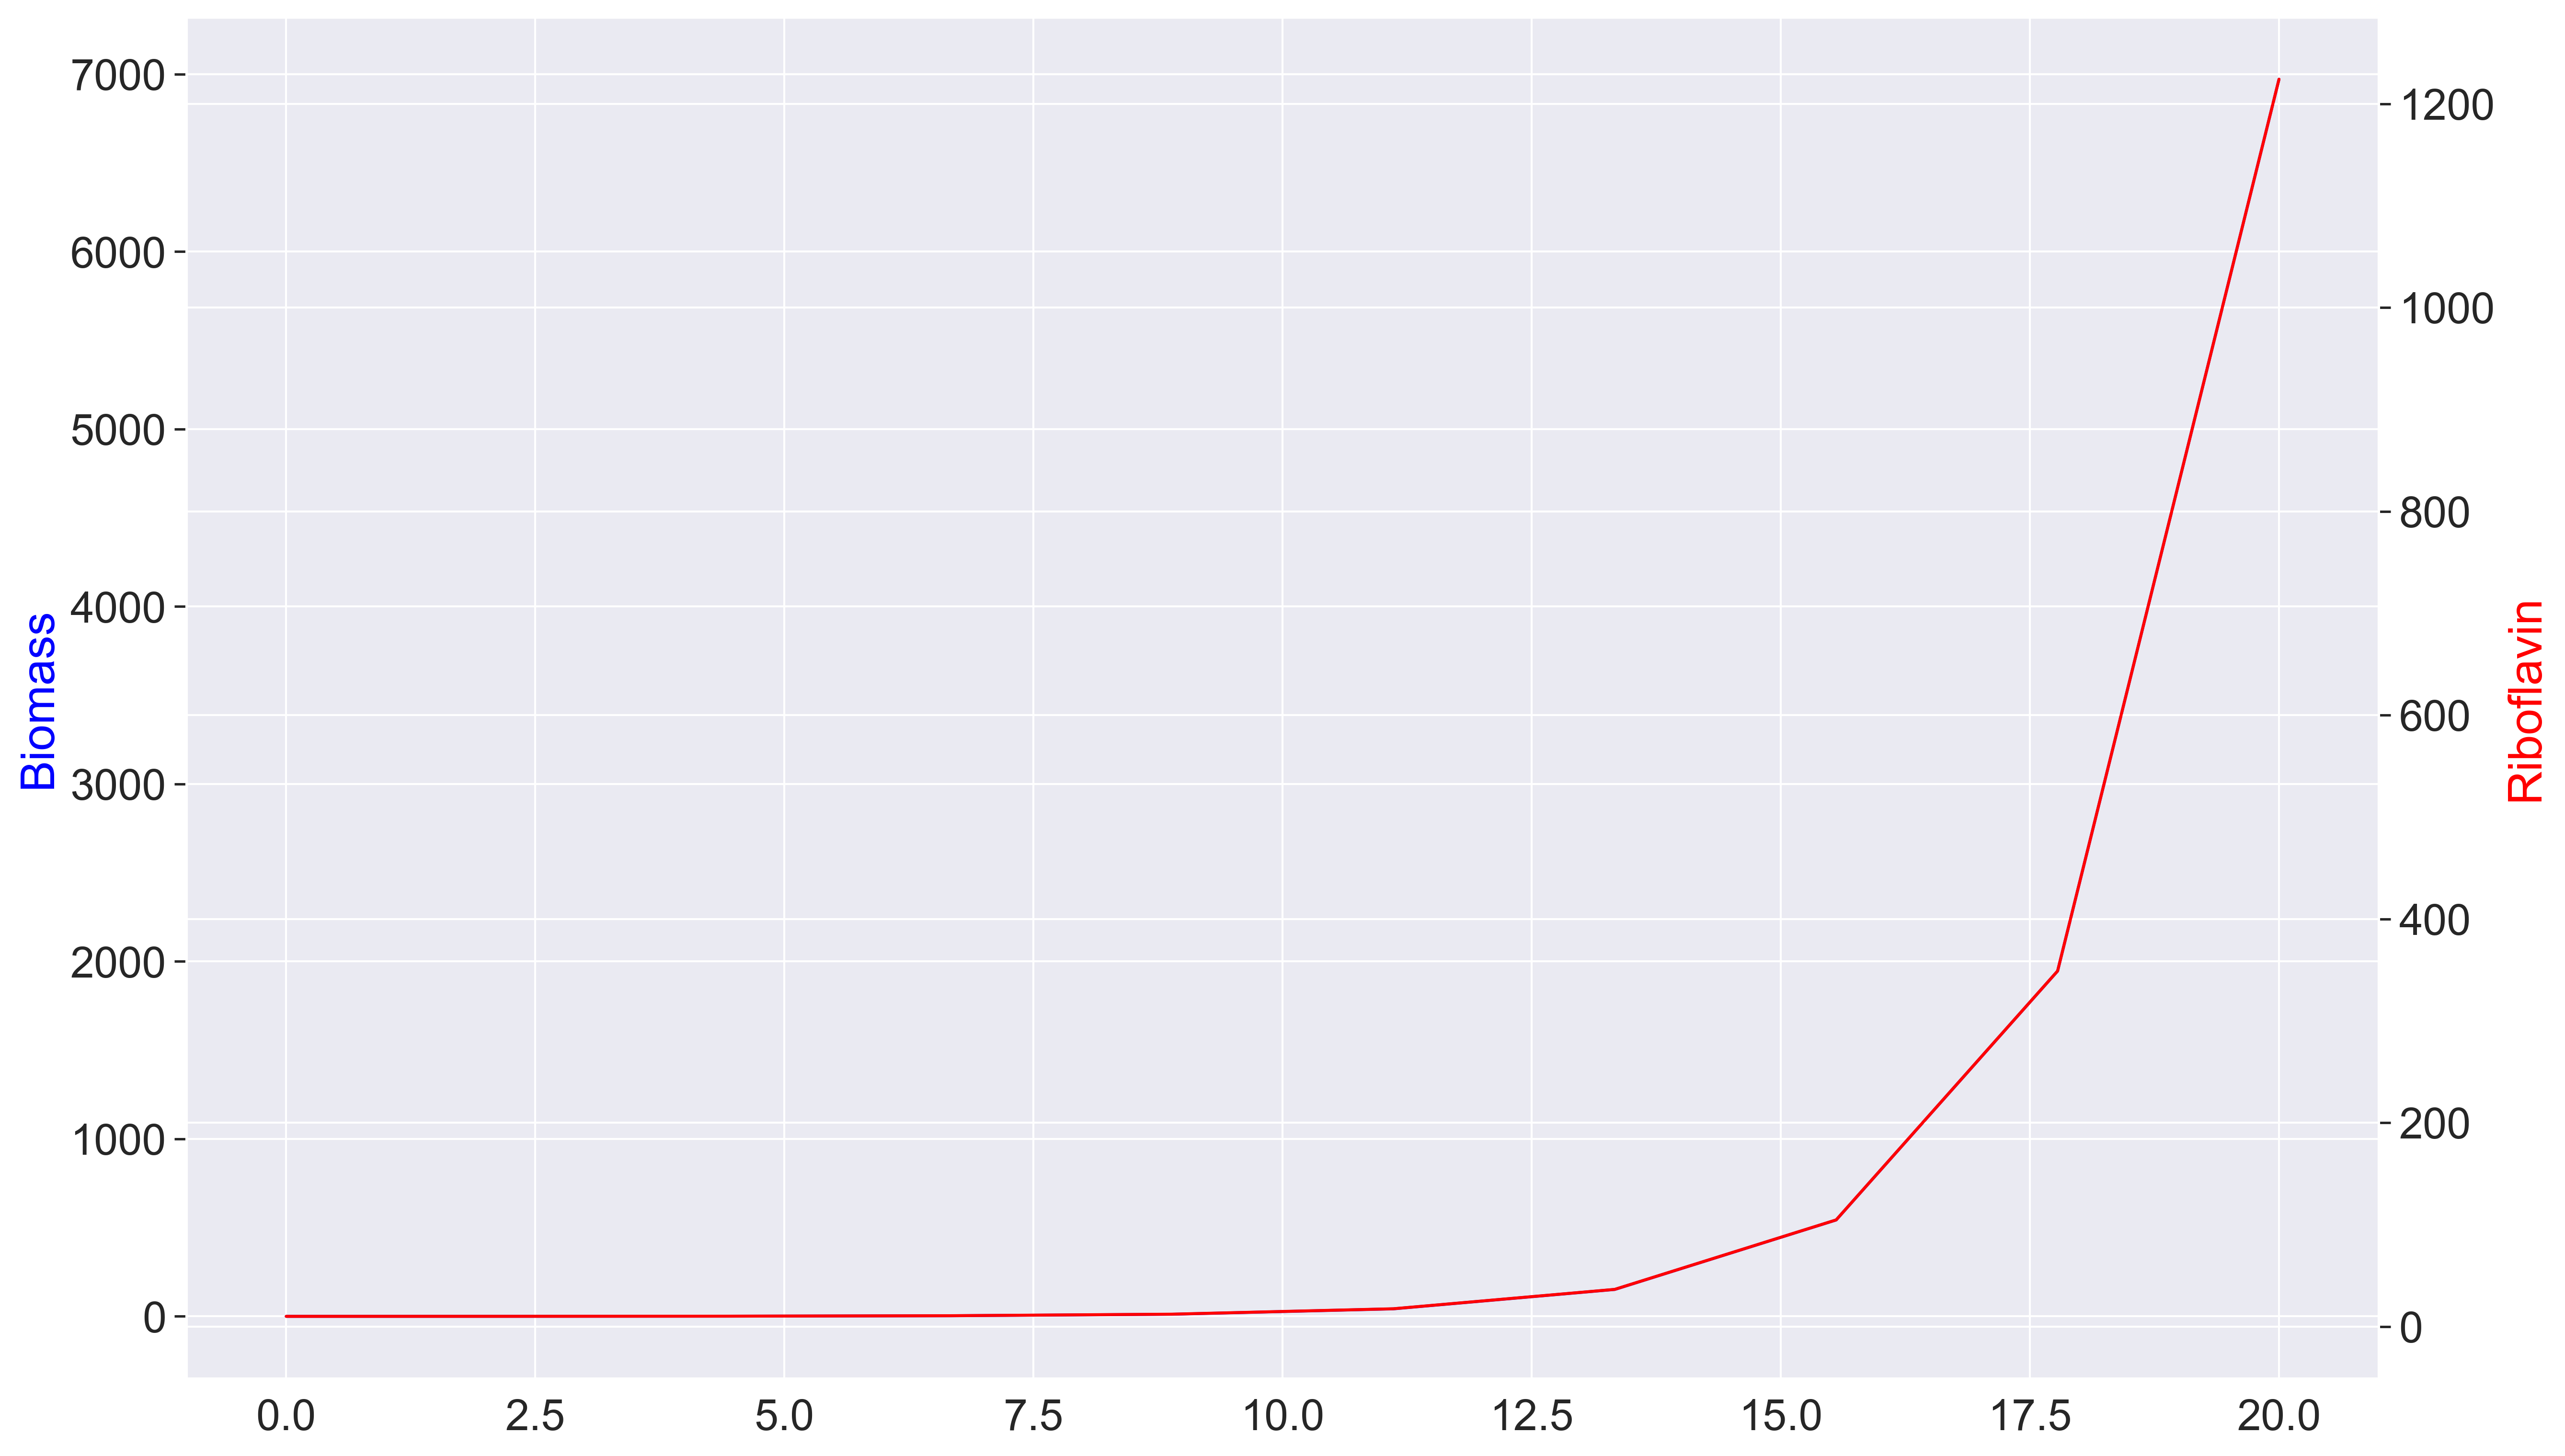

In [25]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Riboflavin', color='r')

In [26]:
model = iYO844 
ts = np.linspace(30, 40, 20)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 40.000: : 175it [22:25,  7.69s/it]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 3.000e+01  3.053e+01 ...  3.947e+01  4.000e+01]
        y: [[ 1.000e-01  1.321e-01 ...  1.652e+01  2.236e+01]
            [ 1.000e+01  1.001e+01 ...  1.296e+01  1.398e+01]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 172
     njev: 1
      nlu: 16

Text(0, 0.5, 'Riboflavin')

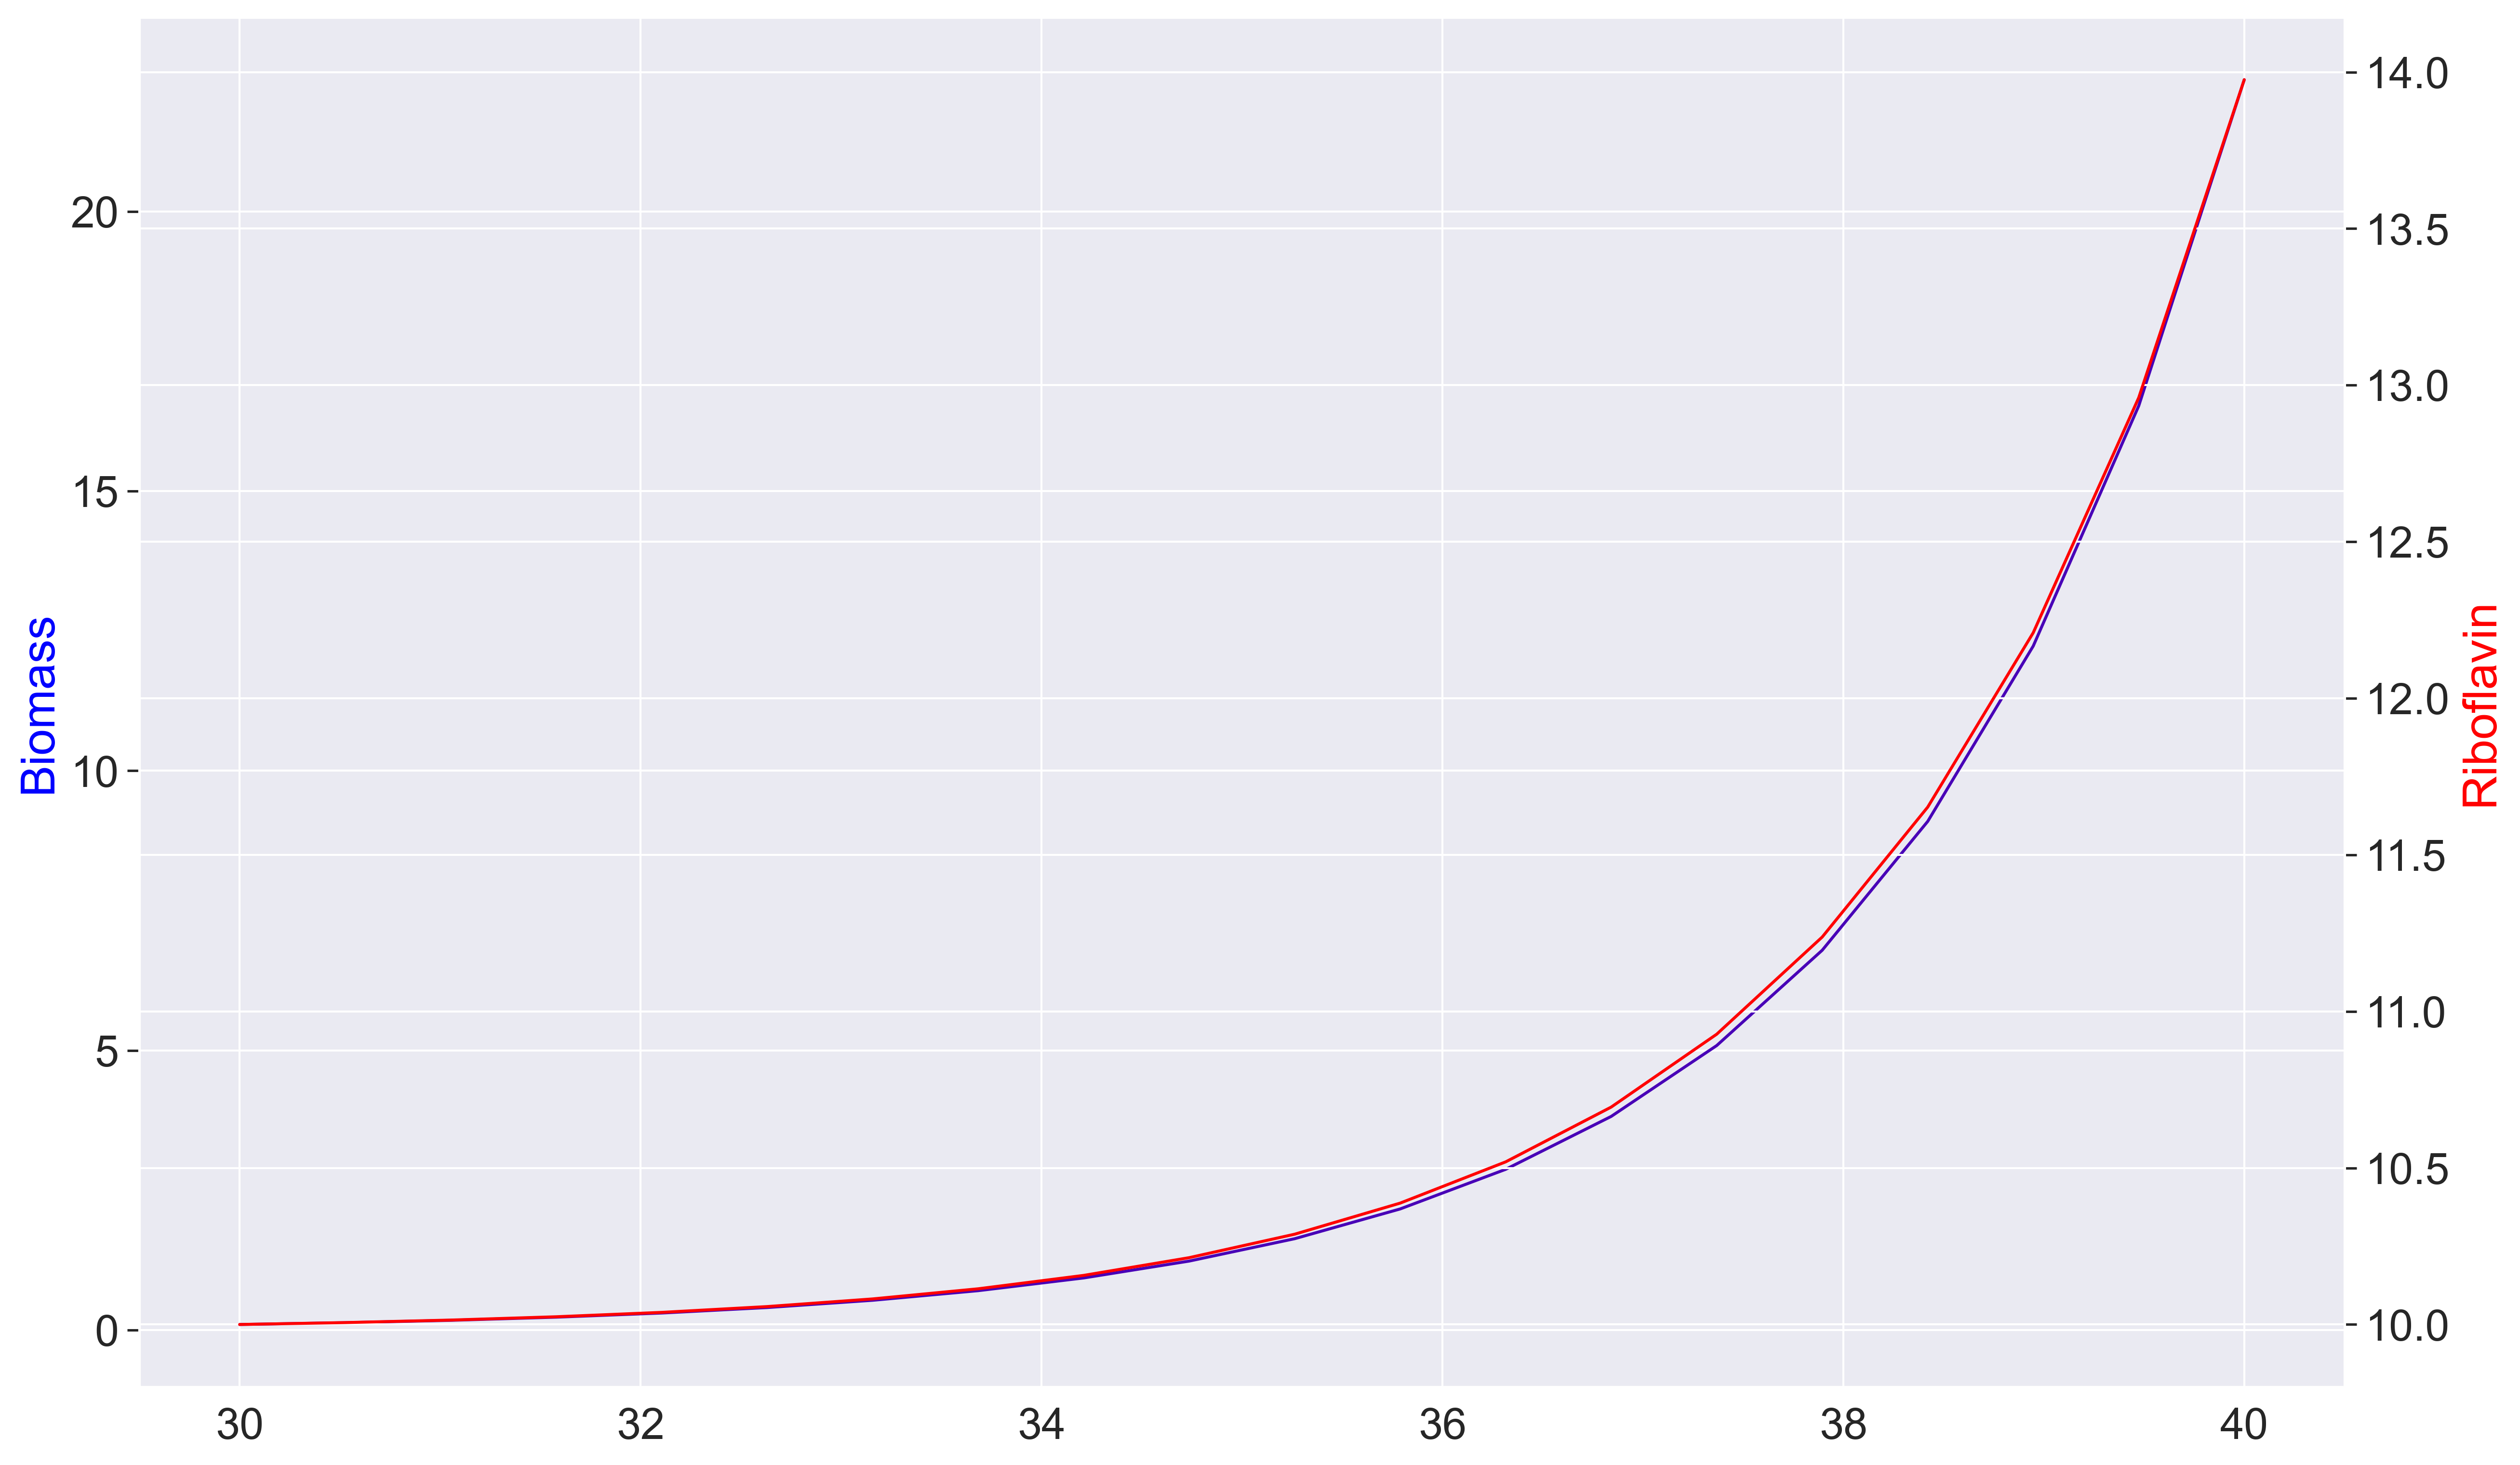

In [27]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Riboflavin', color='r')

**`This shows that Riboflavin production is Growth Coupled but it has a limitation of 0.1 units Riboflavin/h based on the optimization sets.`**

## References:

1. Liu, Y.; Zhang, Q.; Qi, X.; Gao, H.; Wang, M.; Guan, H.; Yu, B. Metabolic Engineering of Bacillus subtilis for Riboflavin Production: A Review. Microorganisms 2023, 11, 164. https://doi.org/10.3390/microorganisms11010164
2. Dauner, M. and Sauer, U. (2001), Stoichiometric growth model for riboflavin-producing Bacillus subtilis. Biotechnol. Bioeng., 76: 132-143. https://doi.org/10.1002/bit.1153
3. Birkenmeier, M., Neumann, S. & Röder, T. Kinetic modeling of riboflavin biosynthesis in Bacillus subtilis under production conditions. Biotechnol Lett 36, 919–928 (2014). https://doi.org/10.1007/s10529-013-1435-8
4. Jia-Rong Zhang, Ying-Ying Ge, Pin-He Liu, Ding-Tao Wu, Hong-Yan Liu, Hua-Bin Li, Harold Corke, Ren-You Gan, Biotechnological Strategies of Riboflavin Biosynthesis in Microbes, Engineering, Volume 12, 2022, Pages 115-127, ISSN 2095-8099, https://doi.org/10.1016/j.eng.2021.03.018. (https://www.sciencedirect.com/science/article/pii/S2095809921002009)
5. Singh, R., Kumar, M., Mittal, A. et al. Microbial metabolites in nutrition, healthcare and agriculture. 3 Biotech 7, 15 (2017). https://doi.org/10.1007/s13205-016-0586-4 
6. Shouyong Jiang, Irene Otero-Muras, Julio R. Banga, Yong Wang, Marcus Kaiser, and Natalio Krasnogor, OptDesign: Identifying Optimum Design Strategies in Strain Engineering for Biochemical Production ACS Synthetic Biology 2022 11 (4), 1531-1541, DOI: http://doi.org/10.1021/acssynbio.1c00610.
7. Oh YK, Palsson BO, Park SM, Schilling CH, Mahadevan R. Genome-scale reconstruction of metabolic network in Bacillus subtilis based on high-throughput phenotyping and gene essentiality data. J Biol Chem. 2007 Sep 28;282(39):28791-28799. doi: http://doi.org/10.1074/jbc.M703759200. Epub 2007 Jun 15. PMID: 17573341.
8. Trembley A., Mahadhavan R., Tutorials 1-9, CHE1125: Modelling and Optimization of Chemical & Biochemical Networks, University of Toronto.